# NLP Project - Glassdoor and Firms'Rating
### Nathalie Bou Farhat, Josephine Gilbert and David Gauthier

In this project we propose to analyse textual data we scrapped from Glassdoor to understand how employees rate their firms and how ratings can be predicted from the different types of comments left by employees. Since Glassdoor keeps millions of record, here to keep the dataset contained we focused on financial business in the UK.
This dataset offers different types of rating and comments. 
The notebook is structured as follows:
1. Introduction to the dataset and preprocessing
2. Data exploration
3. Simple models (non deep learning)
4. Deep learning models (LSTM, transformer)



## Packages and data

In [1]:
!pip install transformers -q

import os
import json
import pandas as pd
import numpy as np
import datetime
from collections import Counter
import missingno as msno
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from wordcloud import WordCloud

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import FastText, vocab
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader

import re 
import string
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import punkt
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.models.phrases import Phrases, Phraser

import random
from string import punctuation
from tqdm import tqdm
from transformers import RobertaModel, RobertaTokenizer, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel

tqdm.pandas()

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 29.5 MB/s 
     |████████████████████████████████| 895 kB 51.2 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 54.3 MB/s 


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Preprocessing Functions

Here, we centralize some cleaning and preprocessing functions that we will use in the following parts. We do not use the same functions for oiur different tasks (simple models, LSTM, transformers).

###Preprocessing functions for the simple models

In [21]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [22]:
def clean_txt(text):
    text = str(text)
    for n in range(10):
        text = text.replace(str(n) , '')
    text = text.lower() #OK
    text = text.replace("(" , " ")#OK
    text = text.replace("_" , " ")#OK
    text = text.replace("\)" , " ") #OK
    text = re.sub('^- - - - -', '', text) # remove from the - from the     
    for a in range(10):
        text = re.sub('^-{a}' , '',text)
    for b in range(10):
        text = re.sub('^- {b}' , '',text)
    for c in range(10):
        text = re.sub('^[.]{c}' , '',text)
    for d in range(10):
        text = re.sub('^[+]{d}' , '',text)
    for e in range(10):
        text = re.sub('^[*]{e}' , '',text)
    for f in range(10):
        text = re.sub('^[!]{f}' , '',text)
    for g in range(10):
        text = re.sub('^[—]{g}' , '',text)
    for h in range(10):
        text = re.sub('^ {h}' , '',text) 
    for i in range(10):
        text = re.sub('^[\^]{i}' , '',text)
    for j in range(10):
        text = re.sub('^[\/]{j}' , '',text)    
    for k in range(10):
        text = re.sub('^[\?]{k}' , '',text)   
    for l in range(10):
        text = re.sub('^\d{l}$' , '',text)   
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)


In [23]:
def clean_txt_2(text):
    text = str(text)
    text = re.sub('\\r' , '',text)   
    text = re.sub('\\n' , '',text)
    text = text.replace('No_headline ' , '')
    text = text.replace('No_pros ' , '')
    text = text.replace('No_cons ' , '')
    
    return text

### Preprocessing routines for LSTM

In [ ]:
def tokenize_pad_numericalize(entry, vocab_stoi, tok, pad=True, max_length=100):
    if pad :
        text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry)]
        padded_text = None
        l = len(text)
        if l < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
        elif l > max_length: padded_text = text[:max_length]
        else:                        padded_text = text
        return padded_text
    else : 
        text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry)]
        return text

We will also use some cleaning and preprocessing functions that are the same as the ones used for transformers. These functions are implemented in the next section.

### Preprocessing routines for transformers

In [ ]:
# Preprocessing routines for TRANSFORMERS

stemmer = WordNetLemmatizer()
tok = TreebankWordTokenizer()

nltk.download('stopwords')
en_stop       = set(nltk.corpus.stopwords.words('english'))
to_be_removed = list(en_stop) + list(punctuation)

# Preprocess text for transformers
def preprocess_transformers(document, full_process=True):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        # Converting to Lowercase
        document = document.lower()
        if full_process:
            # Lemmatization
            tokens = document.split()
            tokens = [stemmer.lemmatize(word) for word in tokens]
            tokens = [word for word in tokens if word not in en_stop]
            tokens = [word for word in tokens if len(word) > 3]
            document = ' '.join(tokens)
        return document

# Make phraser to detect collocations
def show_phrases(tokenized_sentences, threshold=10, shown=15):
  '''Show collocation for a corpus of tokenized sentences.'''
  phrases = Phrases(tokenized_sentences, threshold=threshold)
  i = 0
  #for phrase, score in phrases.export_phrases().items():
  for phrase, score in phrases.export_phrases(tokenized_sentences): # for other gensim version 
    if i>shown:
      break
    else:
      print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

# Accuracy function to evaluate during training
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading the data

In [24]:
# Load Drive Contents
from google.colab import drive
path_files = pathlib.Path('/content/drive/MyDrive/Gdoor')

mnt_point = '/content/drive/'
drive.mount(mnt_point, force_remount = True)
data_path = mnt_point + 'My Drive/Gdoor'
os.chdir(data_path)

Mounted at /content/drive/


In [25]:
# Load Data
data    = pd.read_csv('allreviews.csv', sep=',', encoding='latin-1')
Notkeep = [d for d in data.columns if d not in ['overall_rating','headline','pros','cons','firm','date_review']]
data    = data.drop(columns=Notkeep)
data['date_review'] = pd.to_datetime(data['date_review'])

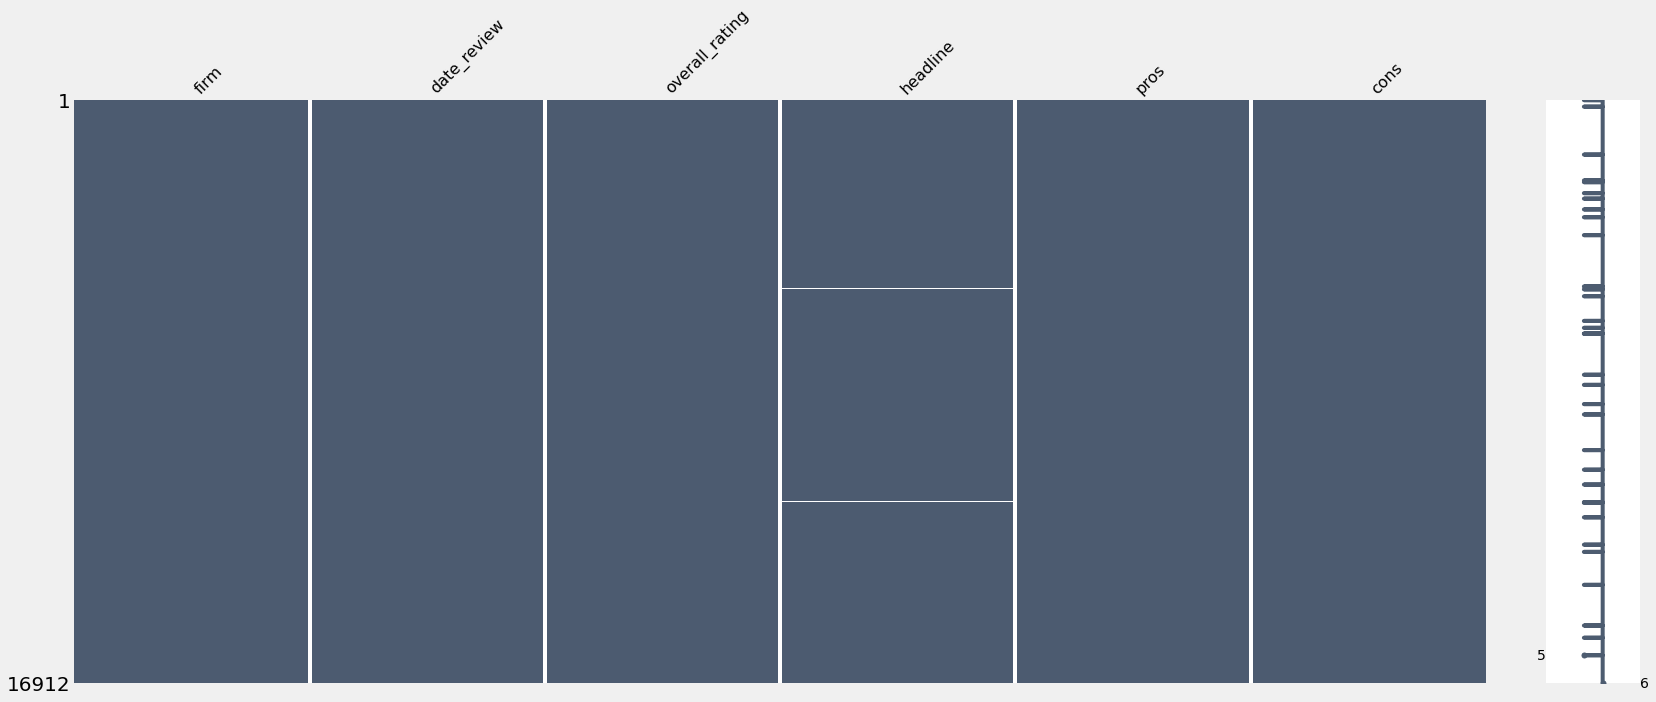

In [26]:
# Check Nans
msno.matrix(data,color=(0.3,0.36,0.44));

In [27]:
# Get column names for each types 
types_str = data.select_dtypes(include='object').columns
types_int = data.select_dtypes(include=[int,float]).columns

# Fill missing according to types
data[types_str] = data[types_str].fillna('NA')
data[types_int] = SimpleImputer(strategy='mean').fit_transform(data[types_int])

# Drop Duplicates
duplicate = data[['headline','pros','cons']].duplicated()
data      = data.loc[duplicate==False]
data = data.reset_index()
print('Drop Duplicated:',duplicate.sum())

Drop Duplicated: 372


## Data preprocessing and exploration

### General description of the dataset

The dataset contains several types of ratings from 1 to 5 on different topics such as work-life balance, career opportunities and so on. For each review there is a headline, a pros and a cons rubric, as well as the date of the review, the firm rated, the title of the reviewer and her current situation.

In [28]:
data['year'] = pd.DatetimeIndex(data['date_review']).year


In [29]:
n_samples, n_columns = data.shape # extract dimensions of the Data
n_data = pd.DataFrame(data.columns)[0] # the columns of our dataset

print('The data contains: {} samples of dimension {}'.format(n_samples, n_columns))

The data contains: 16540 samples of dimension 8


Hereafter, we show some examples of the textual data we focus on when performing LSTM and Transformer analysis.

In [30]:
# Show an example for each grade
for i in range(1,6):
    tmp = data.query('overall_rating==@i').sample(1)
    print(colored(tmp.firm.values[0].upper(),'blue'),'\n'+tmp.headline.values[0],'\nHeadline: ',tmp.headline.values[0],colored('\nPros:','green'),tmp.pros.values[0],colored('\nCons:','red'),tmp.cons.values[0],'\nRating:',colored(tmp.overall_rating.values[0],'red'),'\n')


SUMITOMO_MITSUI_FINANCIAL_GROUP 
Worst Company to work with 
Headline:  Worst Company to work with 
Pros: nothing nothing nothing and nothing 
Cons: Very dominating management
Strict supervision
No work culture
feedback is not considered positively 
Rating: 1.0 

RSA_GROUP 
politics and brand management 
Headline:  politics and brand management 
Pros: Salary.  Work/life depending where you work. 
Cons: Being  connected to the right people is most important, second to your social activity on the company intranet site. 
Rating: 2.0 

METRO_BANK 
What started so well is rapidly changing and not for the better 
Headline:  What started so well is rapidly changing and not for the better 
Pros: Metro is, and always has been, customer focused. They have taken the basic premise that by giving great service and products you will reap the rewards of loyal customers (Fans!) and recommendations. In order to be able to provide this they realise that it is essential to have a happy and productive wor

Some non-semantic features can be informative of the ratings. For instance the number of words in headline, pros and cons seems to be a good indicator of the rating. Longer comments seem to signal a better grade. This seems reasonable since more dedicated reviewers will probably take more time to acknowledge good employment experience.

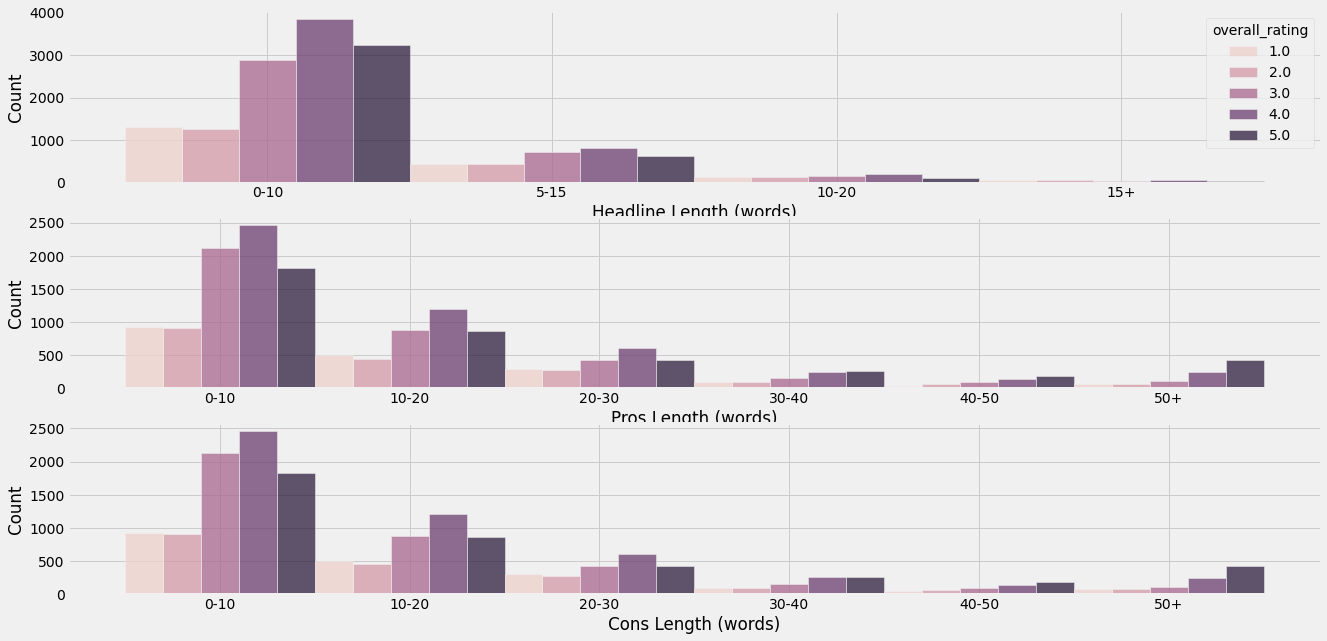

In [31]:
# Word Size Distribution depending on length of headlines, pros and cons
# The length of pros and cons is an important factor to detect polarity in opinions
data['head_len'] = data['headline'].apply(lambda x:len(nltk.word_tokenize(x)))
data['pros_len'] = data['pros'].apply(lambda x:len(nltk.word_tokenize(x)))
data['cons_len'] = data['pros'].apply(lambda x:len(nltk.word_tokenize(x)))

bins_h = list(range(0,20,5))+[1000]
bins   = list(range(0,60,10))+[1000]
data['head_len'] = pd.cut(data['head_len'], bins = bins_h, labels=[str(i)+'-'+str(i+10) for i in bins_h[:-2]]+[str(bins_h[-2])+'+'])
data['pros_len'] = pd.cut(data['pros_len'], bins = bins, labels=[str(i)+'-'+str(i+10) for i in bins[:-2]]+[str(bins[-2])+'+'])
data['cons_len'] = pd.cut(data['cons_len'], bins = bins, labels=[str(i)+'-'+str(i+10) for i in bins[:-2]]+[str(bins[-2])+'+'])

f,ax = plt.subplots(3,1,figsize=(20,10))
ax[0] = sns.histplot(data=data,x='head_len',hue='overall_rating',multiple="dodge",ax=ax[0])
ax[0].set_xlabel('Headline Length (words)')
ax[1] = sns.histplot(data=data,x='pros_len',hue='overall_rating',multiple="dodge",ax=ax[1], legend=False)
ax[1].set_xlabel('Pros Length (words)')
ax[2] = sns.histplot(data=data,x='cons_len',hue='overall_rating',multiple="dodge",ax=ax[2], legend=False)
ax[2].set_xlabel('Cons Length (words)')
plt.show()

While in some of the model below, we focus mostly on raw textual data, it is important to recognize that feature enginering taking length of comments, punctuation upper case and so on maybe extremely helpful for performances.

### Few Plots describing the Data

the most top rated companies (those figures correspond to the top 15)

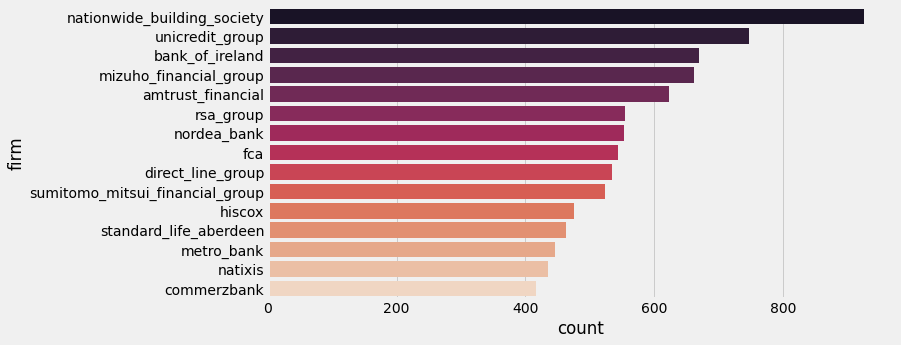

In [32]:

plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (10 , 5))
sns.countplot(y = 'firm' , data = data , palette = 'rocket' , 
              order = data['firm'].value_counts().index[:15])
plt.show()

Density and distribution of the overall_rating label

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


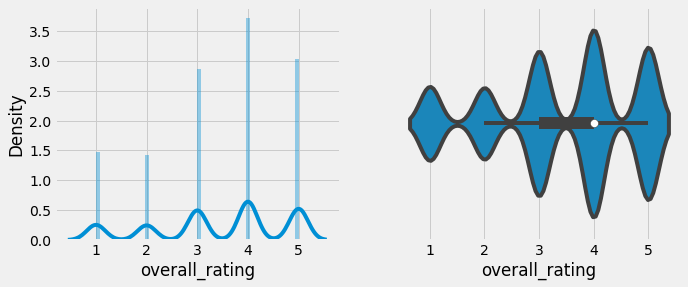

In [33]:
plt.figure(1 , figsize = (10 , 4))
plt.subplot(1 , 2  , 1)
sns.distplot(data['overall_rating'])
data['overall_rating'] = pd.to_numeric(data['overall_rating'])
plt.subplot(1 , 2 , 2)
sns.violinplot(x='overall_rating',data=data)
plt.show()

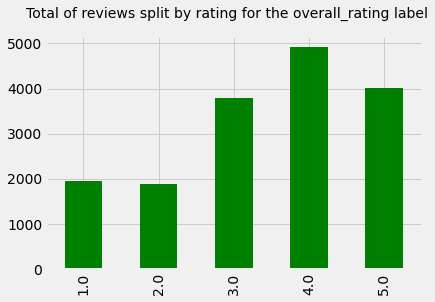

In [34]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
plt.suptitle("Total of reviews split by rating for the overall_rating label", fontsize=14)
data['overall_rating'].value_counts().sort_index(ascending=True).plot.bar(color="green")


The number of reviews for each rating

We can plot the number of reviews per year. Here, this number has clearly increased with time. Their volatility has decreased over the past what coincides with the increase in the quantity of reviews. There seems to be an upward trend in the overall rating level.

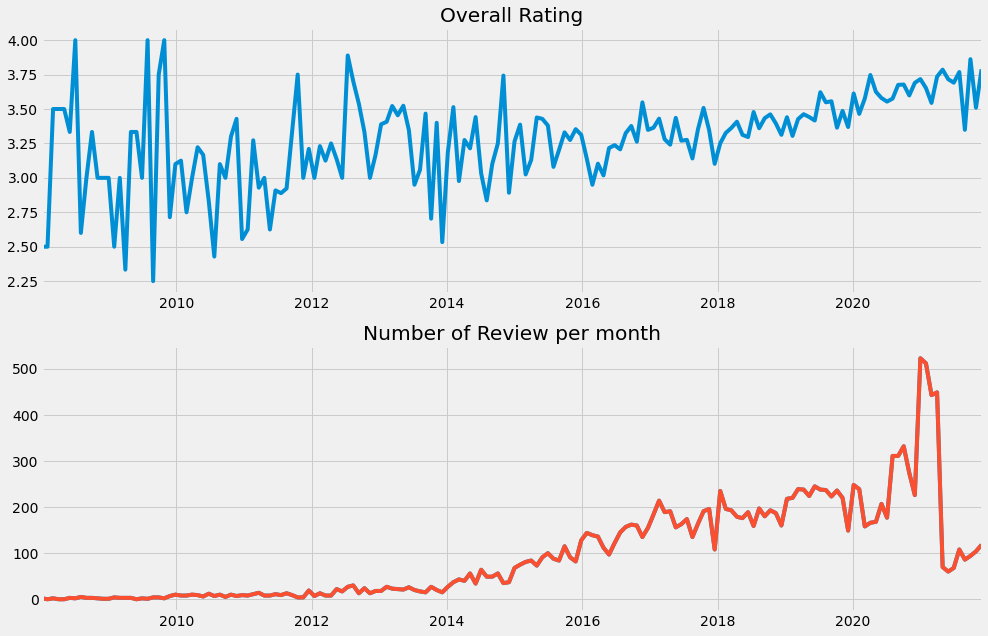

In [35]:
ratings_ts = data[['firm','overall_rating','date_review']].set_index('date_review').groupby([pd.Grouper(freq='30D')]).mean().ffill()
f,ax = plt.subplots(2,1,figsize=(15,10))
ratings_ts.plot(ax=ax[0],title='Overall Rating', legend=False)
data[['firm','overall_rating','date_review']].set_index('date_review').groupby([pd.Grouper(freq='30D')]).count().plot(ax=ax[1],title='Number of Review per month',legend=False)
for axx in ax:axx.set_xlabel(None)
plt.show()

Are the ratings equally balanced ? There are more good marks than bad marks, but this class imbalance is not critical.

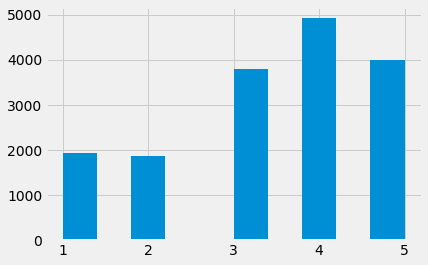

In [36]:
#l'histogramme me parait un petit peu bizarre au niveau du 3 et du 5

plt.hist(data['overall_rating'].astype(int))
plt.xticks(range(1,6))
plt.show()

We can wonder whether the length of a review, and more precisely the length of the `pros` and `cons` fields, is correlated with `overall_rating`. Therefore, we plot some histogramms to observe the link between these variables.

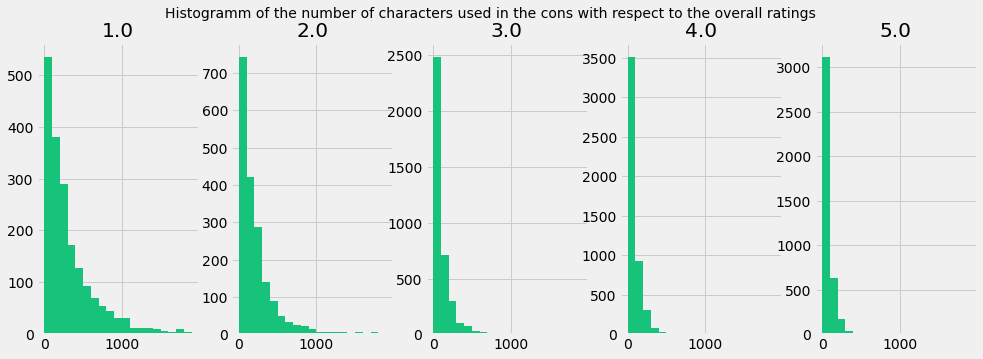

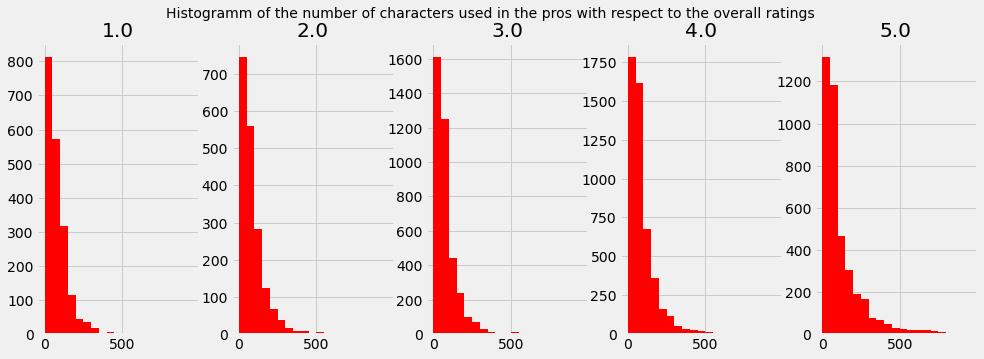

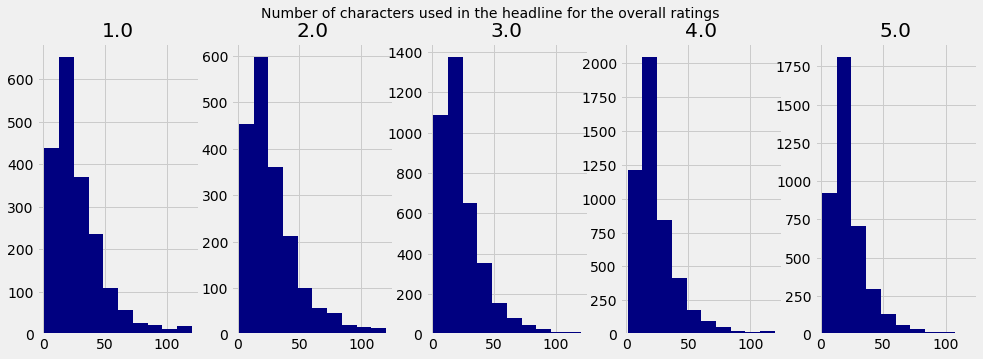

In [37]:
fig,ax=plt.subplots(1,len(sorted(data['overall_rating'].unique())),figsize=(15,5))

plt.suptitle("Histogramm of the number of characters used in the cons with respect to the overall ratings", fontsize=14)
for i in range(len(sorted(data['overall_rating'].unique()))):
    data_len=data[(data['overall_rating']==sorted(data['overall_rating'].unique())[i])&(data['cons'] != 'No_cons')]['cons'].str.len()
    ax[i].hist(data_len,color='#17C37B', bins=range(0,2000,100))
    ax[i].set_title(sorted(data['overall_rating'].unique())[i])
    
fig,ax=plt.subplots(1,len(sorted(data['overall_rating'].unique())),figsize=(15,5))


plt.suptitle("Histogramm of the number of characters used in the pros with respect to the overall ratings", fontsize=14)
for i in range(len(sorted(data['overall_rating'].unique()))):
    data_len=data[(data['overall_rating']==sorted(data['overall_rating'].unique())[i])&(data['pros'] != 'No_pros')]['pros'].str.len()
    ax[i].hist(data_len,color='red', bins=range(0,1000,50))
    ax[i].set_title(sorted(data['overall_rating'].unique())[i])


fig,ax=plt.subplots(1,len(sorted(data['overall_rating'].unique())),figsize=(15,5))


plt.suptitle("Number of characters used in the headline for the overall ratings", fontsize=14)
for i in range(len(sorted(data['overall_rating'].unique()))):
    data_len=data[(data['overall_rating']==sorted(data['overall_rating'].unique())[i]) &(data['headline'] != 'No_headline')]['headline'].str.len()
    ax[i].hist(data_len,color='Navy')
    ax[i].set_title(sorted(data['overall_rating'].unique())[i])


There does not seem to be a clear trend for the length of the `pros` and the `headline`, but for the `cons`, it looks like there are longer sequences when the rating is really bad.





##Simple models

We will start by creating simple models based on the sentimentthat can be useful in predicting the ratings from different comments

###Cleaning the Data

The first step consists in cleaning the text data with various operations:
There are quite many words and characters which are not really required. The objective of this step is to clean noise those are less relevant to find the sentiment of the reviews.
So, we will try to keep only those words which are important and add value.


We cleaned the `headline`, the `pros`and the `cons` rubric and we calculated their length

In [38]:
# Cleaning the data
cleaning = lambda x : clean_txt(x)

data['headline_cleaned'] =  data['headline'].progress_apply(cleaning)
data['pros_cleaned'] = data['pros'].progress_apply(cleaning)
data['cons_cleaned'] = data['cons'].progress_apply(cleaning)

100%|██████████| 16540/16540 [00:28<00:00, 587.73it/s]


In [39]:
#the length of each review

data['headline_len'] = data['headline_cleaned'].apply(lambda x: len(x.split(' ')) )
data['pros_len'] = data['pros_cleaned'].apply(lambda x: len(x.split(' ')) )
data['cons_len'] = data['cons_cleaned'].apply(lambda x: len(x.split(' ')) )

data['headline_len'].fillna(0,inplace=True)
data['pros_len'].fillna(0,inplace=True)
data['cons_len'].fillna(0,inplace=True)


###Data Cleaned Exploration

In this section, we will explore the cleaned data as much as possible. Understand the distribution of words, the polarity and the subjectivity of the reviews for all the firms and by each firm

Here we will combine each type of review by firm in order to see the most frequent words used by each firm 

In [40]:
combined_smry_dict = {}

for comp in data['firm'].unique():
    combined_summary = "" 
    for summary in data['headline_cleaned'][data['firm'] == comp]:
        combined_summary = combined_summary +" "+summary
    
    combined_smry_dict[comp] = combined_summary

data_summary = pd.DataFrame(data=combined_smry_dict , index = [0])
data_summary = pd.DataFrame.copy(data_summary.T)
data_summary.columns = ["summary_corpus"]
data_summary['firm'] = data_summary.index

combined_pros_dict = {}
for comp in data['firm'].unique():
    combined = "" 
    for pros in data['pros_cleaned'][data['firm'] == comp]:
        combined = combined +" "+pros
    
    combined_pros_dict[comp] = combined

data_pros = pd.DataFrame(data=combined_pros_dict , index = [0])
data_pros = pd.DataFrame.copy(data_pros.T)
data_pros.columns = ["pros_corpus"]
data_pros['firm'] = data_pros.index

combined_cons_dict = {}
for comp in data['firm'].unique():
    combined = "" 
    for cons in data['cons_cleaned'][data['firm'] == comp]:
        combined = combined +" "+cons
    
    combined_cons_dict[comp] = combined
data_cons = pd.DataFrame(data=combined_cons_dict , index = [0])
data_cons = pd.DataFrame.copy(data_cons.T)
data_cons.columns = ["cons_corpus"]
data_cons['firm'] = data_cons.index



In [41]:
# all the reviews rubric combined by firm
data_all= pd.DataFrame(data_cons["cons_corpus"]+" "+data_pros["pros_corpus"]+" "+data_summary["summary_corpus"])
data_all.columns = ["All_corpus"]

In [42]:
# all the reviews rubric combined by review
data['All_reviews']=data['headline_cleaned']+" "+ data['pros_cleaned']+" "+data['cons_cleaned']

In [43]:
cleaning_2 = lambda x : clean_txt_2(x)
data_all['All_corpus']= data_all['All_corpus'].apply(cleaning_2)
data['All_reviews'] = data['All_reviews'].apply(cleaning_2)
data['All_reviews_len'] = data['All_reviews'].apply(lambda x: len(x.split(' ')) )

Now that we have cleaned and combined our data, we will start by having an idea of how positive,negative and subjective the reviews are

The sentiment function of textblob returns two properties, polarity, and subjectivity

**Polarity** lies in the range of [-1,1]shows how negative or positive the paragraph is \
Polarity = 0 = neutral \
Polarity < 0 = negative\
Polarity > 0 = positive

**Subjectivity** lies in the range of [0,1]quantifies the amount of personal opinion and factual information contained in the text.The higher subjectivity means that the text contains personal opinion rather than factual information

In [44]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['All_polarity'] = data['All_reviews'].apply(pol)
data['All_subjectivity'] = data['All_reviews'].apply(sub)

#Creating a dataframe combining the two properties, it will be used for the modeling section

data_pol_sub=pd.DataFrame()
data_pol_sub = pd.concat([data_pol_sub,data['All_polarity'],data['All_subjectivity']], axis=1)
data_pol_sub['label']=data['overall_rating']



Based on the histograms plotting the subjectivity of the reviews we can conlude that most of the reviews present personal opinion rather than factual information

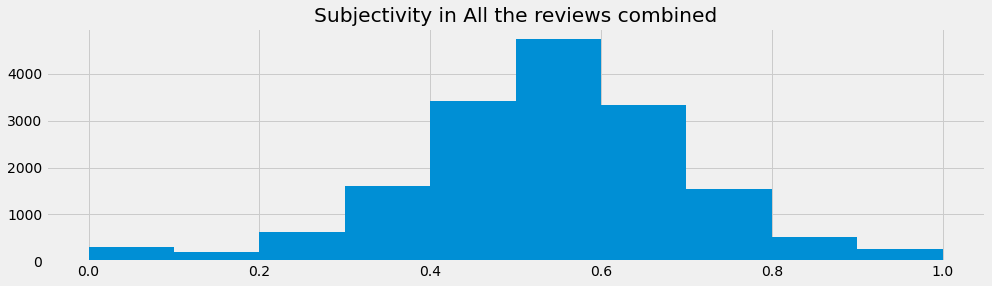

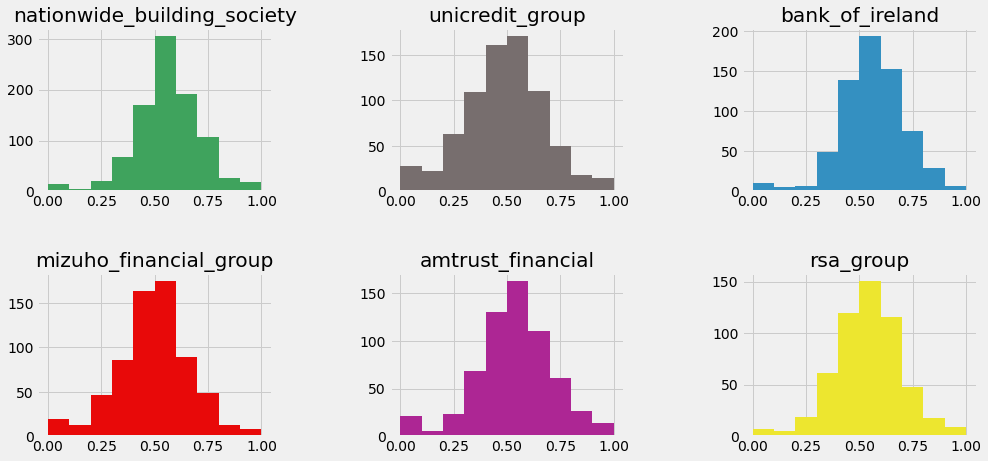

In [45]:
index_companies=data['firm'].value_counts()
colors = ['#3fa35d' , '#776e6e' , '#3490c1' , 
         '#e80909' , '#ad2694'  ,  '#ede62f']

plt.figure(1 , figsize = (15 , 4))
plt.hist(data['All_subjectivity'] )
plt.title('Subjectivity in All the reviews combined')

plt.figure(2 , figsize = (15 , 7))
n = 0 
for comp , c in zip(index_companies.index[:9] , colors):
    n += 1
    plt.subplot(2 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.hist(data['All_subjectivity'][data['firm'] == comp]  ,color = c)
    plt.title(comp)
plt.show()

Based on the histograms plotting the polarity of the reviews we can conlude that most of the reviews present neutral and almost positive feedbacks

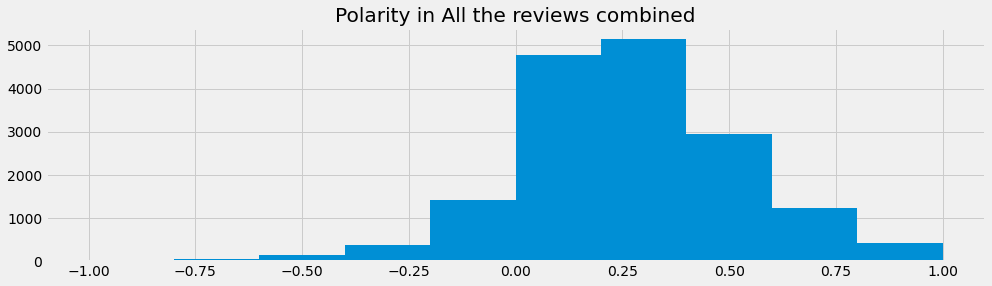

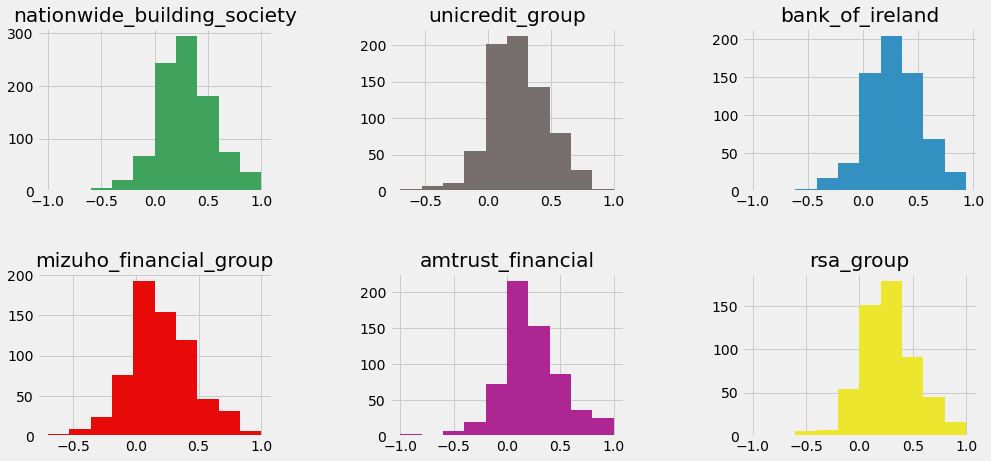

In [46]:
plt.figure(1 , figsize = (15 , 4))
plt.hist(data['All_polarity'] )
plt.title('Polarity in All the reviews combined')

plt.figure(2 , figsize = (15 , 7))
n = 0 
for comp , c in zip(index_companies.index[:9] , colors):
    n += 1
    plt.subplot(2 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.hist(data['All_polarity'][data['firm'] == comp]  ,color = c)
    plt.title(comp)
plt.show()

The Word Cloud presented for each company confirms the polarity histograms that shows most of the time neutral and positive words

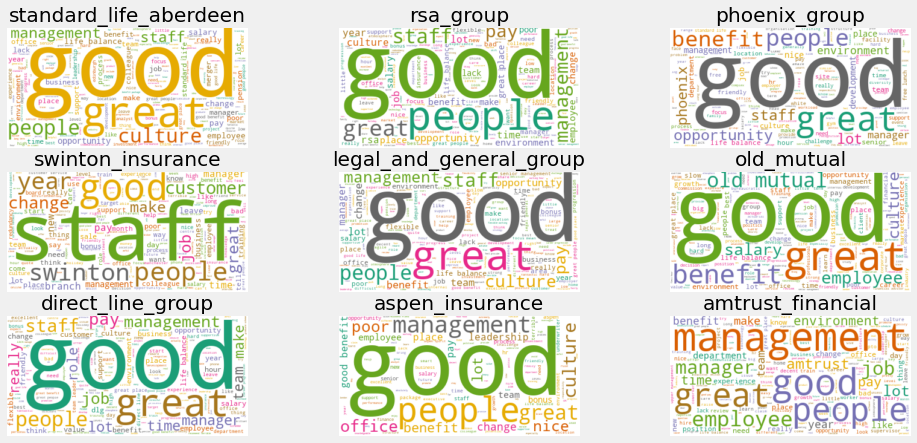

In [47]:
wc = WordCloud(stopwords = text.ENGLISH_STOP_WORDS.union(["work"],["company"],data_summary['firm'].unique()[:100]), 
               background_color = "white" , 
               colormap = "Dark2" ,
               max_font_size = 150 , 
               random_state = 42)

plt.figure(1 , figsize = (15 , 7))
for corpus , i in zip(data_all['All_corpus'].values,range(9)):
    wc.generate(corpus)
    plt.subplot(3 , 3 , i + 1)
    plt.imshow(wc , interpolation="bilinear")
    plt.axis("off")
    plt.title(data_summary.index[i])
plt.show()

Now let's dig a little bit deeper to see the distribution of words for each rating

Text(0.5, 1.0, 'length of Bad, Neutral and Good reviews')

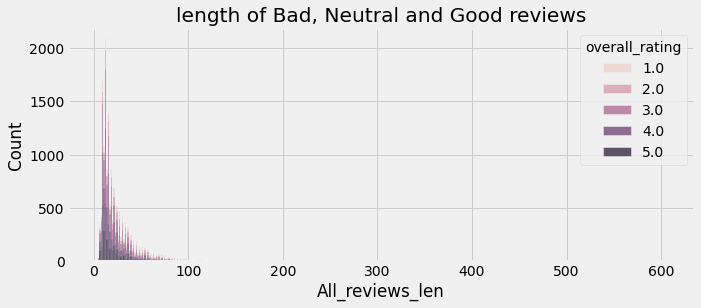

In [48]:
plt.figure(figsize=(10,4))
sns.histplot(data=data , x= 'All_reviews_len' , hue= 'overall_rating', multiple= 'stack').set_title('length of Bad, Neutral and Good reviews')


In [49]:
words = [word for sent in data['All_reviews'] for word in sent.split()]


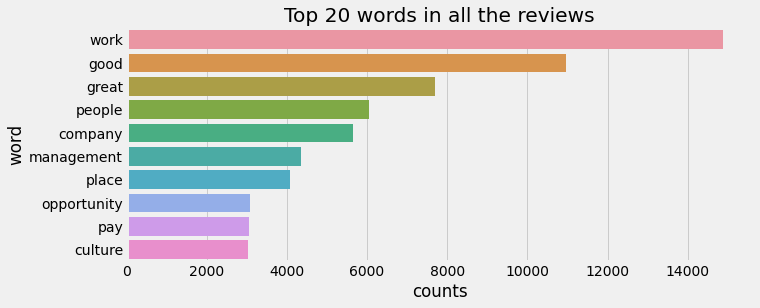

,word,counts
0,work,14885
1,good,10963
2,great,7687
3,people,6046
4,company,5641
5,management,4354
6,place,4078
7,opportunity,3090
8,pay,3047
9,culture,3040


In [50]:
# sorting most frequent word descending order
freq_words = Counter(words)
freq_words_sorted = sorted(freq_words.items(), key=lambda pair: pair[1], reverse=True)
freq_words_data = pd.DataFrame(freq_words_sorted[:10], columns=['word', 'counts'])
plt.figure(figsize=(10, 4))
sns.barplot(data= freq_words_data , x= 'counts', y= 'word')
plt.title('Top 20 words in all the reviews')
plt.show();
freq_words_data.head(10)

In [51]:
def freq_sentiment_words(sentiment, num):

    words = [word for sent in data[data['overall_rating'] == (sentiment)]['All_reviews'] for word in sent.split()]
    freq_words = Counter(words)
    freq_words_sorted = sorted(freq_words.items(), key=lambda pair: pair[1], reverse=True)
    freq_words_data = pd.DataFrame(freq_words_sorted[:num], columns=['word', 'counts'])
    return freq_words_data

def plot_freq(sentiment, st):
 
    plt.figure(figsize=(10, 4))
    sns.barplot(data= freq_sentiment_words(sentiment,10) , x= 'counts', y= 'word')
    plt.title(f'Top 10 words in {st} sentiment')
    plt.show();



Below the most frequent words used for the negative reviews that get a rating of 1 and the words show a neutral state

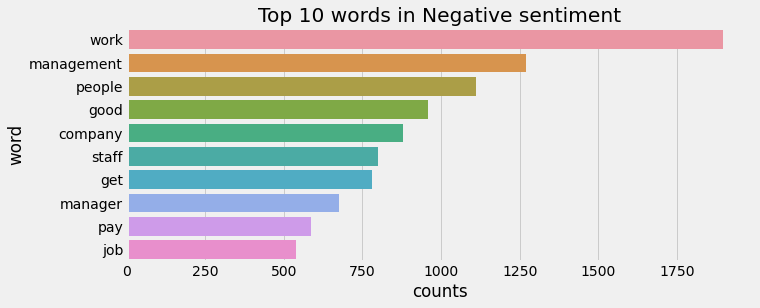

,word,counts
0,work,1897
1,management,1271
2,people,1111
3,good,958
4,company,879
5,staff,801
6,get,779
7,manager,677
8,pay,586
9,job,538


In [52]:
#Rating 1 frequend words

plot_freq(1, 'Negative')
freq_sentiment_words(1,10)


Below the most frequent words used for the reviews that get a rating of 5 and the words are positive and makes sense

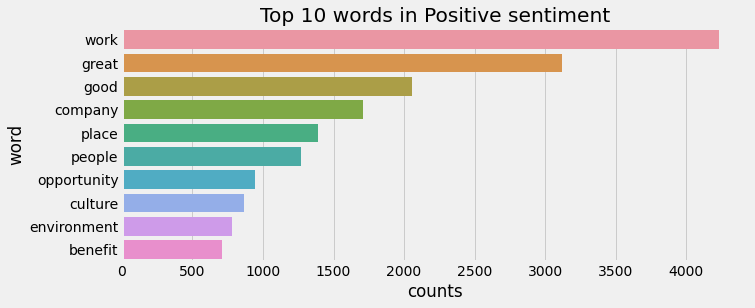

,word,counts
0,work,4230
1,great,3117
2,good,2060
3,company,1706
4,place,1388
5,people,1269
6,opportunity,946
7,culture,865
8,environment,778
9,benefit,710


In [53]:
#Rating 5 frequend words

plot_freq(5, 'Positive')


freq_sentiment_words(5,10)


###Feature engineering 

For the next section we will create some feature engineering for our modelization part. For us to be able to do that we  need to convert the text reviews into features.

Text features can be constructed using various techniques – Sentiment scores,  TF-IDF, Word2Vec and Doc2Vec .


We will start first by adding sentiment analysis features because we can guess that reviewers are highly linked to how they felt about their work experience. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into account the context of the sentences to determine the sentiment scores. For each text, Vader returns 4 values:

*   Neutrality Score
*   Positivity Score
*   Negativity Score
*   an Overall Score that summarizes the previous scores





In [54]:
sid = SentimentIntensityAnalyzer()
data_sentiment = pd.DataFrame()
data_sentiment["sentiments"]= data["All_reviews"].apply(lambda x: sid.polarity_scores(x))
data_sentiment = pd.concat([data_sentiment.drop(['sentiments'], axis=1), data_sentiment['sentiments'].apply(pd.Series)], axis=1)

In [55]:
data_sentiment['label']=data['overall_rating']
data_sentiment.shape

(16540, 5)

the next step will be by computing the TF-IDF (Term Frequency — Inverse Document Frequency) values for every word and every document.

In [56]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['All_reviews']).toarray()
tfidf_data = pd.DataFrame(tfidf, columns = tfidf_vectorizer.get_feature_names_out ())
tfidf_data.columns = ["word_" + str(x) for x in tfidf_data.columns]

In [57]:
tfidf_data.head()

,word_ability,word_able,word_abn,word_absolutely,word_accept,word_access,word_account,word_accountability,word_achieve,word_acquisition,...,word_workload,word_workplace,word_world,word_worth,word_write,word_wrong,word_year,word_yes,word_young,word_zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
tfidf_data['label']=data['overall_rating']


Now we construct the Word2Vec features. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. The advantages of using word embeddings over the TF-IDF are:
*   Dimensionality reduction - significant reduction in the no. of features required to build a model.
*   It capture meanings of the words, semantic relationships and the different types of contexts they are used in.

In [59]:
tokenized_reviews = data['All_reviews'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_reviews,
            size=100, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 4, # no.of cores
) 

model_w2v.train(tokenized_reviews, total_examples= len(data['All_reviews']), epochs=20)

(7105714, 8772320)

In [60]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [61]:
#tokenized_reviews[12485]
#tokenized_reviews[12484]
data['All_reviews']

0        great place work great people lot interest wor...
1        na excellent health benefit profit sharing pla...
2        standard life good work environment office bad...
3        amaze aberdeen never mean leave yard first pla...
4        na nice people work executive level change goo...
                               ...                        
16535    best year work career date centre uk's financi...
16536    realise good people bank leave willingness let...
16537    enrich professional development perspective re...
16538    pleasant place work good work/life balance sal...
16539    review analyst job bank job offer opportunity ...
Name: All_reviews, Length: 16540, dtype: object

In [62]:
wordvec_arrays = np.zeros((len(tokenized_reviews), 100)) 

wordvec_data=pd.DataFrame()
for i in range(len(tokenized_reviews)):
    wordvec_arrays[i,:] = word_vector(tokenized_reviews[i], 100)
wordvec_data = pd.DataFrame(wordvec_arrays)
wordvec_data.columns = ["wordvec_data" + str(x) for x in wordvec_data.columns]


In [63]:
wordvec_data['label']=data['overall_rating']

Finally this step consists in extracting vector representations for every review.

The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What’s interesting is that similar words will have similar representation vectors.

However,Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.


We will instantiate a Doc2Vec model with a vector of 100 dimensions and iterating over the taining corpus 40 times


In [64]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data["All_reviews"].apply(lambda x: x.split(" ")))]
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, window=5, min_count=1, workers=4,alpha=0.1,seed = 23,epochs=40)


We train the Doc2Vec model with our text data


In [65]:
model.build_vocab(documents)
model.train(documents, total_examples=len(data['All_reviews']), epochs=40)
docvec_data = data["All_reviews"].apply(lambda x: model.infer_vector(x.split(" "),alpha=0.025)).apply(pd.Series)
docvec_data.columns = ["docvec_data" + str(x) for x in docvec_data.columns]



In [66]:
docvec_data['label']=data['overall_rating']

###Modeling the new features

Now that we have done with all the pre-modeling stages required to get the data in the proper form and shape, we will be building models on the datasets with different feature sets prepared in the earlier sections — Polarity and subjectivity features, Sentiment analysis features,TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

*   Random Forest
*   Logistic Regression
*   XGBoost





we gathered the 5 dataframe containing our new features that will be used for our modeling:
*   data_sentiment
*   tfidf_data
*   wordvec_data
*   docvec_data
*   data_pol_sub











####1.   Random Forest




In [67]:
X_tfidf_data=tfidf_data.iloc[:,:1000]
y_tfidf_data=tfidf_data.iloc[:,-1:]
X_wordvec_data=wordvec_data.iloc[:,:100]
y_wordvec_data=wordvec_data.iloc[:,-1:]
X_sid_data=data_sentiment.iloc[:,:4]
y_sid_data=data_sentiment.iloc[:,-1:]
X_docvec_data=docvec_data.iloc[:,:100]
y_docvec_data=docvec_data.iloc[:,-1:]
X_pol_sub_data=data_pol_sub.iloc[:,:2]
y_pol_sub_data=data_pol_sub.iloc[:,-1:]


In [68]:
data_New_Feature = pd.DataFrame()
data_New_Feature = pd.concat([data_New_Feature, X_tfidf_data,X_wordvec_data,X_sid_data,X_docvec_data,X_pol_sub_data,data['overall_rating'],], axis=1)

X_all_features=data_New_Feature.iloc[:,:1206]
y_all_features=data_New_Feature.iloc[:,-1:]


In [69]:
Xtrain_all_features, X_test_all_features, ytrain_all_features, y_test_all_features = train_test_split(X_all_features, y_all_features, test_size = 0.3, random_state = 42)
Xtrain_tfidf, X_test_tfidf, ytrain_tfidf, y_test_tfidf = train_test_split(X_tfidf_data, y_tfidf_data, test_size = 0.20, random_state = 42)
Xtrain_wordvec, X_test_wordvec, ytrain_wordvec, y_test_wordvec = train_test_split(X_wordvec_data, y_wordvec_data, test_size = 0.20, random_state = 42)
Xtrain_sid, X_test_sid, ytrain_sid, y_test_sid = train_test_split(X_sid_data, y_sid_data, test_size = 0.20, random_state = 42)
Xtrain_docvec, X_test_docvec, ytrain_docvec, y_test_docvec = train_test_split(X_docvec_data, y_docvec_data, test_size = 0.20, random_state = 42)
Xtrain_pol_sub, X_test_pol_sub, ytrain_pol_sub, y_test_pol_sub = train_test_split(X_pol_sub_data, y_pol_sub_data, test_size = 0.20, random_state = 42)


In [70]:
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf1 = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf2 = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf3 = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf4 = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf5 = RandomForestClassifier(n_estimators = 200, random_state = 42)


In [71]:
rf.fit(Xtrain_all_features.values, ytrain_all_features.values.ravel())
rf1.fit(Xtrain_tfidf, ytrain_tfidf.values.ravel())
rf2.fit(Xtrain_wordvec, ytrain_wordvec.values.ravel())
rf3.fit(Xtrain_sid, ytrain_sid.values.ravel())
rf4.fit(Xtrain_docvec, ytrain_docvec.values.ravel())
rf5.fit(Xtrain_pol_sub, ytrain_pol_sub.values.ravel())

RandomForestClassifier(n_estimators=200, random_state=42)

In [72]:
print('the accuracy of the all features:',rf.score(X_test_all_features,y_test_all_features))
print('the accuracy of the tfidf:',rf1.score(X_test_tfidf,y_test_tfidf))
print('the accuracy of the word2vec:',rf2.score(X_test_wordvec,y_test_wordvec))
print('the accuracy of the sid:',rf3.score(X_test_sid,y_test_sid))
print('the accuracy of the doc2vec:',rf4.score(X_test_docvec,y_test_docvec))
print('the accuracy of the pol_sub:',rf5.score(X_test_pol_sub,y_test_pol_sub))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


the accuracy of the all features: 0.46211205159209995
the accuracy of the tfidf: 0.43349455864570735
the accuracy of the word2vec: 0.45525997581620314
the accuracy of the sid: 0.3304111245465538
the accuracy of the doc2vec: 0.38724304715840385
the accuracy of the pol_sub: 0.3013905683192261


In the Random forest model the word2vec and all the features combined represent the highest accuracy scores for our analysis.
However pol_sub features do not seem to be capturing the right signals as the accuracy score on the test set is quite low.

In [73]:
All_features_columns=X_all_features.columns

In [74]:
feature_importances_df = pd.DataFrame({"feature": All_features_columns, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
1002,wordvec_data2,0.011615
1102,pos,0.010498
1103,compound,0.010299
1100,neg,0.009914
1204,All_polarity,0.009719
1072,wordvec_data72,0.008436
1081,wordvec_data81,0.008228
1003,wordvec_data3,0.007578
1025,wordvec_data25,0.007148
1018,wordvec_data18,0.007103


Let's build the heatmap showing the accuracy results of all the features combined

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Text(0.5, 1.0, 'Accuracy of the Random forest model')

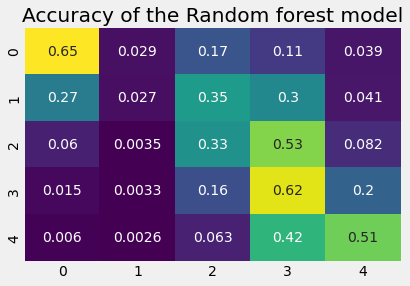

In [75]:
cm = confusion_matrix(y_test_all_features, rf.predict(X_test_all_features), normalize='true') #we normalize over the true labels
sns.heatmap(cm,annot=True,cbar=False,cmap='viridis').set_title('Accuracy of the Random forest model')

####2.   Logistic Regression



In [76]:
lr = LogisticRegression(random_state=0,max_iter=3000,multi_class='multinomial', solver="lbfgs")
lr1 = LogisticRegression(random_state=0,max_iter=3000,multi_class='multinomial', solver="lbfgs")
lr2 = LogisticRegression(random_state=0,max_iter=3000,multi_class='multinomial', solver="lbfgs")
lr3 = LogisticRegression(random_state=0,max_iter=3000,multi_class='multinomial', solver="lbfgs")
lr4 = LogisticRegression(random_state=0,max_iter=3000,multi_class='multinomial', solver="lbfgs")
lr5 = LogisticRegression(random_state=0,max_iter=3000,multi_class='multinomial', solver="lbfgs")


In [77]:
#tostring() is renamed to tobytes() for clarity.
import warnings 
warnings.filterwarnings(action= 'ignore')

lr.fit(Xtrain_all_features, ytrain_all_features.values.ravel())
lr1.fit(Xtrain_tfidf, ytrain_tfidf.values.ravel())
lr2.fit(Xtrain_wordvec, ytrain_wordvec.values.ravel())
lr3.fit(Xtrain_sid, ytrain_sid.values.ravel())
lr4.fit(Xtrain_docvec, ytrain_docvec.values.ravel())
lr5.fit(Xtrain_pol_sub, ytrain_pol_sub.values.ravel())

LogisticRegression(max_iter=3000, multi_class='multinomial', random_state=0)

In [78]:
print('the accuracy of the all features:',lr.score(X_test_all_features,y_test_all_features))
print('the accuracy of the tfidf:',lr1.score(X_test_tfidf,y_test_tfidf))
print('the accuracy of the word2vec:',lr2.score(X_test_wordvec,y_test_wordvec))
print('the accuracy of the sid:',lr3.score(X_test_sid,y_test_sid))
print('the accuracy of the doc2vec:',lr4.score(X_test_docvec,y_test_docvec))
print('the accuracy of the pol_sub:',lr5.score(X_test_pol_sub,y_test_pol_sub))

the accuracy of the all features: 0.4645304312777106
the accuracy of the tfidf: 0.46856106408706166
the accuracy of the word2vec: 0.4703748488512696
the accuracy of the sid: 0.3603385731559855
the accuracy of the doc2vec: 0.4207980652962515
the accuracy of the pol_sub: 0.3555018137847642


In the Logistic Regression model the accuracy seen for the word2vec, the TF-IDF and all the features combined represent the highest accuracy scores for our analysis.
However pol-sub features do not seem to be capturing the right signals as the accuracy score on the test set is quite low.

In [79]:
feature_importances_df = pd.DataFrame({"feature": All_features_columns, "importance": lr.coef_[0]}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
1002,wordvec_data2,2.413812
733,word_recommend,2.005420
63,word_avoid,1.810726
999,word_zero,1.621659
1072,wordvec_data72,1.606918
474,word_knowledge,1.500413
493,word_lie,1.483748
1100,neg,1.420594
665,word_poorly,1.396706
914,word_toxic,1.285906


Text(0.5, 1.0, 'Accuracy of the logistic regression model')

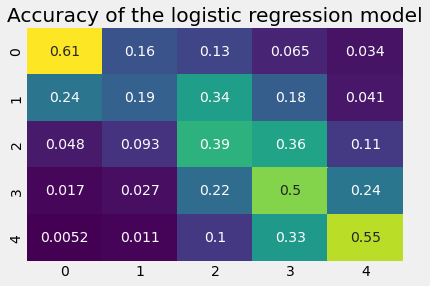

In [80]:
cm1 = confusion_matrix(y_test_all_features, lr.predict(X_test_all_features), normalize='true') #we normalize over the true labels
sns.heatmap(cm1,annot=True,cbar=False,cmap='viridis').set_title('Accuracy of the logistic regression model')


#### 3.  XGboost



In [81]:
from xgboost import XGBClassifier


In [82]:
xgb = XGBClassifier(max_depth=6, n_estimators=200)
xgb1 = XGBClassifier(max_depth=6, n_estimators=200)
xgb2 = XGBClassifier(max_depth=6, n_estimators=200)
xgb3 = XGBClassifier(max_depth=6, n_estimators=200)
xgb4 = XGBClassifier(max_depth=6, n_estimators=200)
xgb5 = XGBClassifier(max_depth=6, n_estimators=200)

In [83]:

xgb.fit(Xtrain_all_features, ytrain_all_features.values.ravel())
xgb1.fit(Xtrain_tfidf, ytrain_tfidf.values.ravel())
xgb2.fit(Xtrain_wordvec, ytrain_wordvec.values.ravel())
xgb3.fit(Xtrain_sid, ytrain_sid.values.ravel())
xgb4.fit(Xtrain_docvec, ytrain_docvec.values.ravel())
xgb5.fit(Xtrain_pol_sub, ytrain_pol_sub.values.ravel())

XGBClassifier(max_depth=6, n_estimators=200, objective='multi:softprob')

In [84]:
print('the accuracy of the all features:',xgb.score(X_test_all_features,y_test_all_features))
print('the accuracy of the tfidf:',xgb1.score(X_test_tfidf,y_test_tfidf))
print('the accuracy of the word2vec:',xgb2.score(X_test_wordvec,y_test_wordvec))
print('the accuracy of the sid:',xgb3.score(X_test_sid,y_test_sid))
print('the accuracy of the doc2vec:',xgb4.score(X_test_docvec,y_test_docvec))
print('the accuracy of the pol_sub:',xgb5.score(X_test_pol_sub,y_test_pol_sub))

the accuracy of the all features: 0.4633212414349053
the accuracy of the tfidf: 0.44709794437726724
the accuracy of the word2vec: 0.4495163240628779
the accuracy of the sid: 0.35489721886336156
the accuracy of the doc2vec: 0.3978234582829504
the accuracy of the pol_sub: 0.34068923821039904


In the XGboost model shows lower accuracy comparing the previous model, but we can see that the word2vec, the tfidf and all the features combined represent the highest accuracy rates.

In [85]:
feature_importances_df = pd.DataFrame({"feature": All_features_columns, "importance": xgb.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
1002,wordvec_data2,0.012422
1100,neg,0.005903
1102,pos,0.005490
1204,All_polarity,0.005036
1103,compound,0.005010
945,word_unicredit,0.004328
293,word_excite,0.004159
605,word_operation,0.004066
380,word_great,0.003960
1018,wordvec_data18,0.003852


Text(0.5, 1.0, 'Accuracy of the Xgboost model')

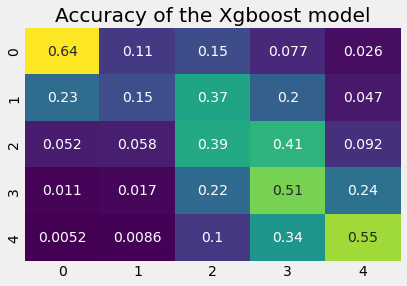

In [86]:
cm3 = confusion_matrix(y_test_all_features, xgb.predict(X_test_all_features), normalize='true') #we normalize over the true labels
sns.heatmap(cm3,annot=True,cbar=False,cmap='viridis').set_title('Accuracy of the Xgboost model')


Now it’s time to wrap-up things. 
First, we cleaned our raw text data, then we learned about 5 different types of feature-set that we can extract from the reviews, and finally we used these feature-sets to build models for sentiment analysis. Word2Vec , TF-IDF  and the combined features turned out to be most useful. Whereas Logistic Regression with Word2Vec features was the best model for this problem. This clearly shows the power of word embeddings in dealing with NLP problems.


### Very basic : prediction of the rate based on the length of the sequences

As we saw just above, the length of a review can give information about the rate. Therefore, we train a few simple predictors to predict the rate only based on a very simple feature : the ratio between the length of the `cons` field and the length of the `pros` field. Here, we treat the problem as a classification one (each of the 5 possible marks is a class) and use logistic regression.

Training score :  0.3860338573155985
Test score :  0.3866384522370012
Coefficients :  [[ 0.72467317]
 [ 0.65699404]
 [ 0.301974  ]
 [-0.37102514]
 [-1.31261607]]


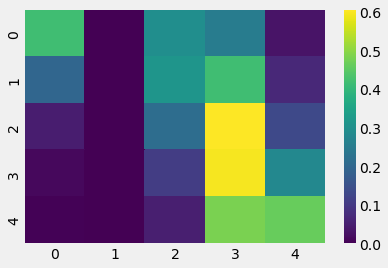

In [87]:
data['len_pros'] = data['pros'].apply(len)
data['len_cons'] = data['cons'].apply(len)
data['ratio_pros_cons'] = data['len_cons']/data['len_pros']

y = np.array(data['overall_rating']).astype(int)-1 #so that they are between 0 and 4 instead of 1 and 5
X = np.array(data['ratio_pros_cons']).astype(float).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print('Training score : ', clf.score(X_train, y_train))
print('Test score : ', clf.score(X_test, y_test))
print('Coefficients : ', clf.coef_)
cm = confusion_matrix(y_test, clf.predict(X_test), normalize='true') #we normalize over the true labels
sns.heatmap(cm,cmap='viridis')

The coefficients are decreasing with ratings : a higher ratio (_i.e._ a larger relative length of the `cons` field) is correlated with a bad mark, as we observed.

The score is rather low but it is significantly better than what a random classifier would do. The confusion matrix is rather messy (no diagonal trend) : it shows that this predictor is not satisfying. 

The main problem is that the predictor never predicts the mark 2 (probably because of class imbalance). Since this model is only here to explore our data, we will not try to solve this problem (for example, we could do over/undersampling).

### A bit more sophisticated : TF-IDF + Logistic regression

This time, we use textual variables to perform a logistic regression. We vectorize our text using TD-IDF with n-grams from 1 to 5.

Note : here, we do not use the `recs` field, because we consider that it could make the classifying task too easy (as it contains expressions such as "recommend" or "don't recommend", it gives substantial information about whether the rating is going to be good or bad).

Training score :  0.6495364772269246
Test score :  0.4602478839177751


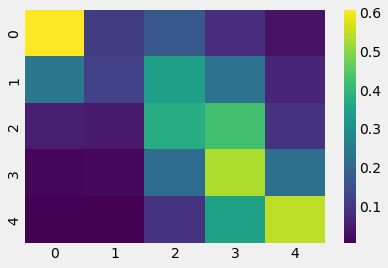

In [88]:
X = data['headline_cleaned']+' '+data['pros_cleaned']+' '+data['cons_cleaned']
y = np.array(data['overall_rating'])-1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

vectorizer = TfidfVectorizer(min_df=20, ngram_range=(1,5))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

clf2 = LogisticRegression(max_iter=200).fit(X_train_vect, y_train)
print('Training score : ', clf2.score(X_train_vect, y_train))
print('Test score : ', clf2.score(X_test_vect, y_test))
cm = confusion_matrix(y_test, clf2.predict(X_test_vect), normalize='true') #we normalize over the true labels
sns.heatmap(cm,cmap='viridis')

The score is even higher, and the confusion matrix tends to a diagonal shape. It shows that this predictor does a pretty good job, despite being extremly simple. We can consider that the accuracy achieved here is our baseline, _i.e._ every model that is more complex should do better than TD-IDF+Logistic regression.

## Deep learning models

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))

DEVICE =  CPU


### LSTM

#### Preprocessing and tokenization for LSTM

In [ ]:
cols = ['overall_rating', 'headline','pros','cons']

df = data[cols]

df.fillna(' ',inplace=True)
df['headline'].astype(str)
df['pros'].astype(str)
df['cons'].astype(str)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


0                             No obvious cons to highlight
1           Haven't really given bonus or salary increases
2                      Bad pay compared to other companies
3        Who doesn't know the feeling of one thing lead...
4        Executive level change not a good thing \r\nSt...
                               ...                        
16535    I can not think of any cons for the thirteen m...
16536    'Bank speak'    The Bank's style of drafting i...
16537    The remuneration is not competitive and the re...
16538    Salary is low compared to market rates in othe...
16539    Salaries are good to live on but not as high a...
Name: cons, Length: 16540, dtype: object

For the text embedding, we use Fasttext (the model takes a few minutes to load).

In [ ]:
pretrained_vectors = FastText(language='en')
pretrained_vocab = vocab(pretrained_vectors.stoi, min_freq=0)

unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)

pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(2,pretrained_embeddings.shape[1]),pretrained_embeddings))
stoi = pretrained_vocab.get_stoi()
tok = TreebankWordTokenizer()

In [ ]:
all_sentences = df[['headline','pros','cons']].applymap(lambda x: nltk.word_tokenize(preprocess_transformers(x, full_process=False)))
all_sentences = all_sentences.melt().value.to_list()
# Some examples
show_phrases(all_sentences,threshold=100)

phrases = Phrases(all_sentences, delimiter=b'oo' ,threshold=100)
phraser = Phraser(phrases)

Expression : b'post merger', score = 308.69476372924646
Expression : b'below market', score = 139.01120141038874
Expression : b'long term', score = 127.88590657880219
Expression : b'old boys', score = 129.42171771257227
Expression : b'stepping stone', score = 3697.4562937062933
Expression : b'mixed bag', score = 1788.536997885835
Expression : b'post merger', score = 308.69476372924646
Expression : b'below market', score = 139.01120141038874
Expression : b'micro managed', score = 318.0098463627875
Expression : b'software developer', score = 246.64081632653057
Expression : b'early stage', score = 290.16566626650666
Expression : b'graduate scheme', score = 118.32736278292921
Expression : b'customer service', score = 107.28875957054393
Expression : b'graduate scheme', score = 118.32736278292921
Expression : b'going downhill', score = 124.5917525773196
Expression : b'aberdeen asset', score = 198.77302631578945


In [ ]:
#we use the same function for transformers and for LSTMs
df['headline'] = df['headline'].progress_apply(lambda x : preprocess_transformers(x, full_process=False))
df['pros'] = df['pros'].progress_apply(lambda x : preprocess_transformers(x, full_process=False))
df['cons'] = df['cons'].progress_apply(lambda x : preprocess_transformers(x, full_process=False))

df['headline'] = df['headline'].progress_apply(lambda x: ' '.join(phraser[word_tokenize(x)]))
df['pros'] = df['pros'].progress_apply(lambda x: ' '.join(phraser[word_tokenize(x)]))
df['cons'] = df['cons'].progress_apply(lambda x: ' '.join(phraser[word_tokenize(x)]))

100%|██████████| 16540/16540 [00:00<00:00, 84689.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 16540/16540 [00:00<00:00, 39726.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 16540/16540 [00:00<00:00, 31157.85it/s]
/usr/local/lib/python3.7/dist-packages/i

In [ ]:
pad = True
#we use different lengths for each field, because the headlines are usually much shorter than the pros and cons
df['tokenized_headline'] = df['headline'].progress_apply(lambda x : tokenize_pad_numericalize(x, stoi, tok, pad, max_length=20))
df['tokenized_pros'] = df['pros'].progress_apply(lambda x : tokenize_pad_numericalize(x, stoi, tok, pad, max_length=80))
df['tokenized_cons'] = df['cons'].progress_apply(lambda x : tokenize_pad_numericalize(x, stoi, tok, pad, max_length=100))

100%|██████████| 16540/16540 [00:01<00:00, 11615.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 16540/16540 [00:01<00:00, 8347.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 16540/16540 [00:02<00:00, 6654.36it/s]


In [ ]:
df[['pros', 'tokenized_pros']].head()

,pros,tokenized_pros
0,great people and lots of interesting work,"[344, 65, 9, 3931, 6, 2288, 172, 1, 1, 1, 1, 1..."
1,excellent health benefits and profitoosharing ...,"[3375, 733, 4152, 9, 0, 1195, 1, 1, 1, 1, 1, 1..."
2,good work environment in offices,"[280, 172, 1803, 8, 2896, 1, 1, 1, 1, 1, 1, 1,..."
3,aberdeen never meant to leave the yard in the ...,"[7349, 508, 2073, 13, 1260, 4, 2061, 8, 4, 49,..."
4,nice people to work with,"[2835, 65, 13, 172, 24, 1, 1, 1, 1, 1, 1, 1, 1..."


#### Dataset and dataloader 

Here, we create a custom dataset class and instanciate the dataloaders that we will need for the training.

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, data, args):
        self.data = data
        self.args = args
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        item = {
                'rate' : int(self.data.iloc[idx]['overall_rating'])-1, #so that all grades are between 0 and 4 instead of 1 and 5
                'headline' : torch.as_tensor(self.data.iloc[idx]['tokenized_headline']),
                'pros' : torch.as_tensor(self.data.iloc[idx]['tokenized_pros']),
                'cons' : torch.as_tensor(self.data.iloc[idx]['tokenized_cons'])
        }
        return item

In [ ]:
data_train, data_test_val = train_test_split(df, test_size=0.7)
data_test, data_val = train_test_split(data_test_val,test_size=0.5)
del data_test_val

In [ ]:
args = {'bsize': 16}

train_loader = DataLoader(ReviewsDataset(data_train, args), batch_size=args['bsize'], shuffle=True, drop_last=True)
del data_train 
val_loader = DataLoader(ReviewsDataset(data_val, args), batch_size=args['bsize'], shuffle=True, drop_last=True)  
del data_val
test_loader = DataLoader(ReviewsDataset(data_test, args), batch_size=args['bsize'], shuffle=True, drop_last=True) 
del data_test

#### Training and inference loops

In [ ]:
def train(model, optimizer, ep, args):
  model.train()
  loss_it, acc_it = list(), list()
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep+1), total=train_loader.__len__()):
    batch = {'headline': batch['headline'].to(device), 'pros': batch['pros'].to(device), 'cons': batch['cons'].to(device), 'rate': batch['rate'].type(torch.LongTensor).to(device)}
    optimizer.zero_grad()
    logits = model(batch['headline'], batch['pros'], batch['cons'])
    # since our dataset is unbalanced, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['rate'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['rate'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(5)) ] )
    b_weights = b_weights.to(device)

    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    loss = loss_function(logits, batch['rate']) #.unsqueeze(1))

    loss.backward()
    optimizer.step()

    loss_it.append(loss.item())

    _, tag_seq  = torch.max(logits, 1)

    correct = (tag_seq.flatten() == batch['rate'].flatten()).float().sum()
    acc = correct / batch['rate'].flatten().size(0)
    acc_it.append(acc.item())

  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  print("%s : (%s %s) (%s %s)" % (colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))
  return loss_it, loss_it_avg


def inference(target, loader, model):
  model.eval()
  loss_it, acc_it, f1_it = list(), list(), list()
  preds, trues = list(), list()

  for it, batch in enumerate(loader):
    with torch.no_grad():
      batch = {'headline': batch['headline'].to(device), 'pros': batch['pros'].to(device), 'cons': batch['cons'].to(device), 'rate': batch['rate'].type(torch.LongTensor).to(device)}
      logits = model(batch['headline'], batch['pros'], batch['cons'])

      b_counter = Counter(batch['rate'].detach().cpu().tolist())
      b_weights = torch.tensor( [ sum(batch['rate'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(5)) ] )
      b_weights = b_weights.to(device)
      loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss = loss_function(logits, batch['rate']) #.unsqueeze(1))
      loss_it.append(loss.item())

      _, tag_seq  = torch.max(logits, 1)

      correct = (tag_seq.flatten() == batch['rate'].flatten()).float().sum()
      acc = correct / batch['rate'].flatten().size(0)
      acc_it.append(acc.item())
      
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['rate'].cpu().detach().tolist())

  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'green'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it


def run_epochs(model, args):

  args['device'] =device
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])
  val_ep_losses = list()
  val_losses = list()
  train_ep_losses = list()

  for ep in range(args['max_eps']):
    train_loss_it, train_loss_it_ep = train(model, optimizer, ep, args)
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    val_ep_losses.append(val_loss_it_avg)
    train_ep_losses.append(train_loss_it_ep)
    val_losses = val_losses + val_loss_it

  return val_ep_losses, val_losses, train_ep_losses

#### Definition of the model

Here, we create one LSTM layer for each input (`headline`, `pros` and `cons`) and concatenate the output of these layers into a vector that is fed into a hidden layer. Finally, we add alinear classifier (linear + softmax).

In [ ]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim, batch_size, pretrained_vectors=None):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.lstm_headline = torch.nn.LSTM(input_dim,hidden_dim, batch_first=True)  
        self.lstm_pros = torch.nn.LSTM(input_dim,hidden_dim, 2, batch_first=True)  
        self.lstm_cons = torch.nn.LSTM(input_dim,hidden_dim, 2, batch_first=True)  
        self.softmax = torch.nn.Softmax(dim=1)
        self.relu = torch.nn.ReLU()
        self.hidden_headline = self.init_hidden() #hidden state of the lstm layer for headline text
        self.hidden_pros = self.init_hidden() #same for pros
        self.hidden_cons = self.init_hidden() #same for cons
        self.hidden_layer2 = torch.nn.Linear(hidden_dim*3, hidden_dim2)
        self.classification_layer = torch.nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(0.25) #we add dropout to prevent overfitting

    
    def init_hidden(self):
        return (torch.autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim)),
                torch.autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim)))

    def forward(self, x_headline, x_pros, x_cons): 
        h_headline  = self.ebd(x_headline)
        h_pros = self.ebd(x_pros)
        h_cons = self.ebd(x_cons)
        h_headline, self.hidden_headline = self.lstm_headline(h_headline)
        h_pros, self.hidden_pros = self.lstm_pros(h_pros)
        h_cons, self.hidden_cons = self.lstm_cons(h_cons)
        h = torch.cat((h_headline[:,-1,:], h_pros[:,-1,:], h_cons[:,-1,:]),1)
        h  = self.relu(self.hidden_layer2(h))
        h = self.dropout(h)
        h = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

#### Instanciation and training

In [ ]:
batch_size = args['bsize']
input_dim  = 300 #fasttext embedding dimension
hidden_dim = 100
hidden_dim2 = 50
output_dim = 5 #only five possible grades


lstm_model = LSTMModel(input_dim, hidden_dim, hidden_dim2, output_dim, batch_size, pretrained_vectors=pretrained_vectors.vectors)
lstm_model.to(device)

LSTMModel(
  (ebd): Embedding(2519370, 300)
  (lstm_headline): LSTM(300, 100, batch_first=True)
  (lstm_pros): LSTM(300, 100, num_layers=2, batch_first=True)
  (lstm_cons): LSTM(300, 100, num_layers=2, batch_first=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (hidden_layer2): Linear(in_features=300, out_features=50, bias=True)
  (classification_layer): Linear(in_features=50, out_features=5, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Training this model with the default parameters entered here takes approximately 10 minutes when using a GPU. 20 epochs were enough for these parameters (the val loss stops decreasing after that) for us, but it might be different for another training. 

We tried several learning rates 'by hand', and also the use of a scheduler, but it dd not really improve the performance so we just kept one learning rate.

In [ ]:
args.update({'max_eps': 30, 'lr': 0.002, 'device': 'cuda', 'cuda': 0})
print('device', device)

loss_list_ep_val_lstm, loss_list_val_lstm, loss_list_ep_train_lstm = run_epochs(lstm_model, args)

device cuda


Epoch 1:: 100%|██████████| 155/155 [00:06<00:00, 25.12it/s]


Training : (loss 1.6067398409689626) (acc 0.20040322580645162)
validation : (loss 1.6016684856679704) (acc 0.26614583333333336)


Epoch 2:: 100%|██████████| 155/155 [00:05<00:00, 28.85it/s]


Training : (loss 1.57800133228302) (acc 0.26229838709677417)
validation : (loss 1.5422210223144954) (acc 0.29635416666666664)


Epoch 3:: 100%|██████████| 155/155 [00:05<00:00, 30.05it/s]


Training : (loss 1.5586125958350396) (acc 0.27923387096774194)
validation : (loss 1.5424901333120133) (acc 0.31302083333333336)


Epoch 4:: 100%|██████████| 155/155 [00:05<00:00, 29.73it/s]


Training : (loss 1.5236478736323695) (acc 0.32298387096774195)
validation : (loss 1.5343769656287298) (acc 0.278125)


Epoch 5:: 100%|██████████| 155/155 [00:05<00:00, 28.82it/s]


Training : (loss 1.5098609432097405) (acc 0.3235887096774194)
validation : (loss 1.5104833053217994) (acc 0.3824652777777778)


Epoch 6:: 100%|██████████| 155/155 [00:05<00:00, 29.53it/s]


Training : (loss 1.5051009239688997) (acc 0.34173387096774194)
validation : (loss 1.5133540325694614) (acc 0.3423611111111111)


Epoch 7:: 100%|██████████| 155/155 [00:05<00:00, 28.89it/s]


Training : (loss 1.4917169855486963) (acc 0.3625)
validation : (loss 1.5065404726399316) (acc 0.3854166666666667)


Epoch 8:: 100%|██████████| 155/155 [00:05<00:00, 28.41it/s]


Training : (loss 1.4768836129096246) (acc 0.3848790322580645)
validation : (loss 1.4962220350901285) (acc 0.3638888888888889)


Epoch 9:: 100%|██████████| 155/155 [00:05<00:00, 27.87it/s]


Training : (loss 1.4805234909057616) (acc 0.38125)
validation : (loss 1.4982048710187277) (acc 0.37222222222222223)


Epoch 10:: 100%|██████████| 155/155 [00:05<00:00, 27.53it/s]


Training : (loss 1.477708427367672) (acc 0.40625)
validation : (loss 1.4911615550518036) (acc 0.39079861111111114)


Epoch 11:: 100%|██████████| 155/155 [00:05<00:00, 26.89it/s]


Training : (loss 1.463334850342043) (acc 0.40826612903225806)
validation : (loss 1.4949833194414774) (acc 0.3597222222222222)


Epoch 12:: 100%|██████████| 155/155 [00:06<00:00, 22.32it/s]


Training : (loss 1.450331401055859) (acc 0.41875)
validation : (loss 1.4896277467409769) (acc 0.39652777777777776)


Epoch 13:: 100%|██████████| 155/155 [00:05<00:00, 26.41it/s]


Training : (loss 1.4601761248803908) (acc 0.4155241935483871)
validation : (loss 1.5241995917426214) (acc 0.33611111111111114)


Epoch 14:: 100%|██████████| 155/155 [00:06<00:00, 22.25it/s]


Training : (loss 1.4691005337622858) (acc 0.39838709677419354)
validation : (loss 1.503900600804223) (acc 0.34913194444444445)


Epoch 15:: 100%|██████████| 155/155 [00:06<00:00, 22.83it/s]


Training : (loss 1.4479800701141357) (acc 0.42439516129032256)
validation : (loss 1.4971893383396997) (acc 0.3685763888888889)


Epoch 16:: 100%|██████████| 155/155 [00:05<00:00, 26.10it/s]


Training : (loss 1.4531386467718308) (acc 0.43528225806451615)
validation : (loss 1.5116417076852586) (acc 0.3536458333333333)


Epoch 17:: 100%|██████████| 155/155 [00:05<00:00, 28.23it/s]


Training : (loss 1.4553577538459532) (acc 0.411491935483871)
validation : (loss 1.50590624610583) (acc 0.37135416666666665)


Epoch 18:: 100%|██████████| 155/155 [00:06<00:00, 25.54it/s]


Training : (loss 1.4623045736743558) (acc 0.4284274193548387)
validation : (loss 1.4933089507950676) (acc 0.3704861111111111)


Epoch 19:: 100%|██████████| 155/155 [00:05<00:00, 25.88it/s]


Training : (loss 1.426399109440465) (acc 0.4544354838709677)
validation : (loss 1.5100604255994161) (acc 0.3807291666666667)


Epoch 20:: 100%|██████████| 155/155 [00:05<00:00, 26.38it/s]


Training : (loss 1.4219299470224689) (acc 0.46975806451612906)
validation : (loss 1.4927224271827273) (acc 0.3680555555555556)


Epoch 21:: 100%|██████████| 155/155 [00:06<00:00, 24.83it/s]


Training : (loss 1.3950757718855336) (acc 0.4971774193548387)
validation : (loss 1.5054519103633033) (acc 0.37222222222222223)


Epoch 22:: 100%|██████████| 155/155 [00:06<00:00, 24.79it/s]


Training : (loss 1.379892268488484) (acc 0.5034274193548387)
validation : (loss 1.5005295044846005) (acc 0.3651041666666667)


Epoch 23:: 100%|██████████| 155/155 [00:06<00:00, 22.19it/s]


Training : (loss 1.371022883538277) (acc 0.519758064516129)
validation : (loss 1.4875680572456784) (acc 0.3970486111111111)


Epoch 24:: 100%|██████████| 155/155 [00:07<00:00, 21.92it/s]


Training : (loss 1.3863190181793705) (acc 0.5018145161290323)
validation : (loss 1.4871019151475695) (acc 0.390625)


Epoch 25:: 100%|██████████| 155/155 [00:07<00:00, 21.48it/s]


Training : (loss 1.3594913713393673) (acc 0.5387096774193548)
validation : (loss 1.497738959391912) (acc 0.378125)


Epoch 26:: 100%|██████████| 155/155 [00:06<00:00, 22.90it/s]


Training : (loss 1.3479094797565092) (acc 0.5389112903225807)
validation : (loss 1.5149072759681277) (acc 0.3845486111111111)


Epoch 27:: 100%|██████████| 155/155 [00:06<00:00, 23.29it/s]


Training : (loss 1.3478956445570915) (acc 0.5540322580645162)
validation : (loss 1.5036783721711902) (acc 0.36319444444444443)


Epoch 28:: 100%|██████████| 155/155 [00:07<00:00, 21.73it/s]


Training : (loss 1.3288336238553446) (acc 0.5592741935483871)
validation : (loss 1.4880623526043362) (acc 0.4088541666666667)


Epoch 29:: 100%|██████████| 155/155 [00:06<00:00, 23.01it/s]


Training : (loss 1.3172734275940925) (acc 0.5800403225806452)
validation : (loss 1.4964440511332617) (acc 0.40069444444444446)


Epoch 30:: 100%|██████████| 155/155 [00:06<00:00, 23.40it/s]


Training : (loss 1.3028183014162125) (acc 0.5931451612903226)
validation : (loss 1.5039655221833124) (acc 0.39045138888888886)


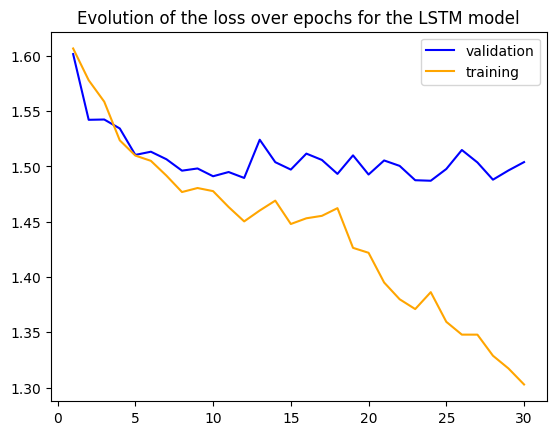

In [ ]:
plt.plot(range(1,args['max_eps']+1),loss_list_ep_val_lstm, color='blue', label='validation')
plt.plot(range(1,args['max_eps']+1), loss_list_ep_train_lstm, color='orange', label='training')
plt.legend(['validation','training'])
plt.title('Evolution of the loss over epochs for the LSTM model')
plt.show()

In [ ]:
#You might want to delete some variables to save memory because the model is heavy
del stoi
del phrases
del all_sentences

In [ ]:
import gc #garbage collecor

In [ ]:
gc.collect()

650

#### Test

In [ ]:
import sklearn
lstm_model.eval() #swith to eval mode
trues, preds, _, _, _, _ = inference('test', test_loader, lstm_model)
print('MSE :',sklearn.metrics.mean_squared_error(trues, preds))
print('MAE :',sklearn.metrics.mean_absolute_error(trues, preds))
print('Accuracy :',sklearn.metrics.accuracy_score(trues, preds))

test : (loss 1.4927966442373064) (acc 0.39114583333333336)
MSE : 1.3395833333333333
MAE : 0.8222222222222222
Accuracy : 0.39114583333333336


The confusion matrix is quite consistent, with a diagonal trend, which indicates that although the model often makes mistakes (see accuracy score), it predicts ratings that are close to the true ones most of the time.

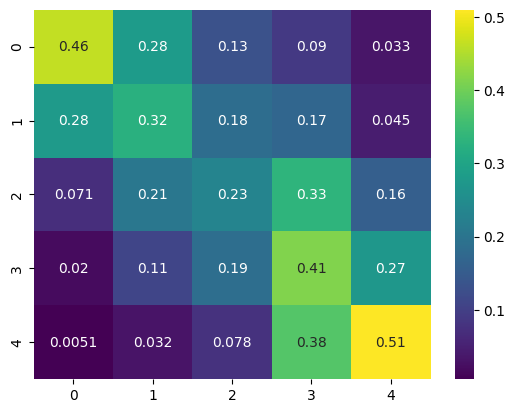

In [ ]:
sns.heatmap(sklearn.metrics.confusion_matrix(trues, preds, normalize='true'), annot=True,cmap='viridis')
plt.show()

### Transformers

Reports

In [ ]:
df = data[['overall_rating','headline','pros','cons','date_review']]


In this chapter we use the Bert transformers to predict ratings from textual data.
Here we standardize the dataset (remove multiple spaces, upper caps) but we keep all the words as the complete syntax of a sentence can be 

We used two different models. Bert-tiny is used to test the process. We then proceed to the estimation using Bert.

In [ ]:
# Set test to true for fast mode
test = False
if test:
    tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')
else:
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

#### Preprocessing for Transformers

Since the models need inputs of equal length, we need to pad sequences tokenized sentences. 
We provide the maximum length based on the larges size of headline. On top of the word ids, the model requires an attention mask to indicate where the input sentences are padded or not.

In [ ]:
# Get all cleaned sentences
all_sentences = df[['headline','pros','cons']].applymap(lambda x: nltk.word_tokenize(preprocess_transformers(x, full_process=False)))
all_sentences = all_sentences.melt().value.to_list()
# Show some collocations
show_phrases(all_sentences,threshold=100)
# Build Phraser
phrases = Phrases(all_sentences, delimiter=b'oo' ,threshold=100)
phraser = Phraser(phrases)

NameError: ignored

In [ ]:
# Data maker for the transfomer
def make_inputs(df,feature):
    minutes_transformers = df[['date_review',feature]].set_index('date_review').copy()
    # standardize text
    minutes_transformers['sentence_treated'] = minutes_transformers[feature].apply(lambda x: preprocess_transformers(x, full_process=False))
    # Apply phraser
    minutes_transformers['sentence_treated'] = minutes_transformers['sentence_treated'].apply(lambda x: ' '.join(phraser[nltk.word_tokenize(x)]))
    # Set max lenght
    max_len = minutes_transformers['sentence_treated'].apply(lambda x:len(nltk.word_tokenize(x))).quantile(0.95)
    max_len = np.min((max_len,200)).astype(int)

    encoded_corpus = tokenizer(text=minutes_transformers['sentence_treated'].tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=max_len,
                            return_attention_mask=True)
                            
    print('The maximum sentence lenght for the transformers input is',max_len)
    input_ids      = encoded_corpus['input_ids']
    attention_mask = encoded_corpus['attention_mask']
    return input_ids, attention_mask

# We take headline, pros and cons to feed to the transformer
input_head, mask_head = make_inputs(df,'headline')
input_pros, mask_pros = make_inputs(df,'pros')
input_cons, mask_cons = make_inputs(df,'cons')

inputs = input_head, input_pros, input_cons, mask_head, mask_pros, mask_cons

In [ ]:
# Make Targets
labels = df.overall_rating.astype(int).to_numpy() - 1

Here we construct train and test data loaders.

In [ ]:
# Paramters for data loaders
test_size  = 0.3
seed       = 42
batch_size = 32

# Make splits for the different sets
train_index, test_index = train_test_split(range(0,len(labels)), test_size=test_size,random_state=seed, stratify=labels)
valid_index, test_index = train_test_split(test_index, test_size=0.5,random_state=seed, stratify=labels[test_index])

# Dataloaders with mask tensors
def create_dataloaders(inputs, split_index, labels, batch_size):
    tensor_input  = tuple(torch.tensor(input_)[split_index] for input_ in inputs)
    labels_tensor = torch.tensor(labels)[split_index]
    dataset    = TensorDataset(*tensor_input, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader
 
# Create train/valid/test sets
train_dataloader = create_dataloaders(inputs, train_index ,labels, batch_size)
valid_dataloader = create_dataloaders(inputs, valid_index ,labels, batch_size)
test_dataloader  = create_dataloaders(inputs, test_index ,labels, batch_size)
 
# Verify dataloader with some examples
for i in range(3):
    sample_head, sample_pros, sample_cons, mask_head, mask_pros, mask_cons, label_sample = next(iter(train_dataloader))
    id_ = random.choice(range(batch_size))
    print('\nLabel:',label_sample[id_].numpy()
    ,'\nSentence Head:',tokenizer.decode(sample_head[id_])
    ,'\nPadding:',mask_head[id_].numpy()
    ,'\nSentence Pros:',tokenizer.decode(sample_pros[id_])
    ,'\nPadding:',mask_pros[id_].numpy()
    ,'\nSentence Cons:',tokenizer.decode(sample_cons[id_])
    ,'\nPadding:',mask_cons[id_].numpy(),)

#### Optimization Settings

We use Adam gradient descent that combines decaying averages of past and past squared gradients and generally offers good performances. We add a linear scheduler for the learning rate to smooth the optimization process.

In [ ]:
# Optimization Settings
epochs      = 50
patience    = 3
optimizer   = torch.optim.AdamW(model.parameters(),lr=5e-5,eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler   = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_function = nn.CrossEntropyLoss()

In [ ]:

# Here we define the model
class RobertaRegressor(nn.Module):
    def __init__(self, device, test, input_len, drop_rate = 0.2, freeze=True):       
        super(RobertaRegressor, self).__init__()

        self.input_len = input_len

        if test:            
            D_in, D_hidden, D_out = 128, 200, 5
            self.roberta1   = RobertaModel.from_pretrained('prajjwal1/bert-tiny').to(device)
            self.roberta2   = RobertaModel.from_pretrained('prajjwal1/bert-tiny').to(device)
            self.roberta3   = RobertaModel.from_pretrained('prajjwal1/bert-tiny').to(device)
        else:
            D_in, D_hidden, D_out = 768, 200, 5
            self.roberta1   = AutoModel.from_pretrained("bert-base-uncased").to(device)
            self.roberta2   = AutoModel.from_pretrained("bert-base-uncased").to(device)
            self.roberta3   = AutoModel.from_pretrained("bert-base-uncased").to(device)
            
        if freeze:
            for param in self.roberta1.parameters():
                param.requires_grad = False
            for param in self.roberta2.parameters():
                param.requires_grad = False
            for param in self.roberta3.parameters():
                param.requires_grad = False
        self.transformers = [self.roberta1,self.roberta2,self.roberta3]
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(input_len*D_in, D_hidden),
            nn.ReLU(),            
            nn.Dropout(drop_rate),
            nn.Linear(D_hidden, D_hidden),
            nn.ReLU(),
            nn.Linear(D_hidden, D_out)).to(device)
    def forward(self, batch_inputs_masks):
        cl_output = []
        for ii in range(self.input_len):
            transformer = self.transformers[ii]
            outputs     = transformer(batch_inputs_masks[ii], batch_inputs_masks[ii+self.input_len])
            cl_output  += [outputs[1]]
        all_t_output = torch.hstack(cl_output)
        outputs = self.regressor(all_t_output)
        outputs = F.softmax(outputs,dim = 1)
        return outputs

# We take advantage of GPUs to speed up training
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

# Build Model
model = RobertaRegressor(device,test,3,freeze=False,drop_rate=0.1)

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

#### Model Description

We use either Bert or tiny Bert to predict the ratings from our textual data 'headline', 'pros' and 'cons'.

In [ ]:
training_stats = []

def model_main(model, optimizer, scheduler, loss_function, epochs,      
          train_dataloader, eval_dataloader,device, clip_value=2,last_loss=np.inf,trigger_times=1):
    for epoch in range(epochs):
        total_train_loss = 0
        print('Epoch - {} / {}'.format(epoch+1,epochs,))        
        # Training
        model.train()
        t = tqdm(enumerate(train_dataloader))
        for _, batch in t:
            batch_inputs_masks_labels = tuple(b.to(device) for b in batch)
            batch_labels = batch_inputs_masks_labels[-1]
            batch_inputs_masks = batch_inputs_masks_labels[:-1]
            # Clear previous gradient
            model.zero_grad()
            # Model Forward
            outputs = model(batch_inputs_masks)
            # Compute loss
            loss    = loss_function(outputs,batch_labels)
            total_train_loss += loss.item()
            # Optimization Steps
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

            t.set_description('Loss: {:.4f}'.format(loss.item()))               

        # Evaluation of the models
        model.eval()
        total_eval_accuracy, total_eval_loss = 0, 0
        for step, batch in enumerate(eval_dataloader):
            batch_inputs_masks_labels = tuple(b.to(device) for b in batch)
            batch_labels = batch_inputs_masks_labels[-1]
            batch_inputs_masks = batch_inputs_masks_labels[:-1]
            with torch.no_grad(): 
                outputs = model(batch_inputs_masks) 
                loss    = loss_function(outputs,batch_labels)
                total_eval_loss += loss.item()
                total_eval_accuracy += accuracy(outputs.to('cpu').numpy(),batch_labels.to('cpu').numpy())

        # We calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)  
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(eval_dataloader)
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(eval_dataloader)        
        print("Training Loss: {:.2f} - Validation Loss: {:.2f} - Validation Accuracy: {:.2f}\n{:}".format(avg_train_loss,avg_val_loss,avg_val_accuracy,'=='*50))

        # Record all statistics from this epoch.
        training_stats.append(
            {   'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
            }
        )
        # Early Stopping
        if loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model, training_stats
        else:
            trigger_times = 0

        # Update loss
        last_loss = loss

    return model, training_stats
if False:
  # Train the model
  model, stats = model_main(model, optimizer, scheduler, loss_function, epochs,
                train_dataloader, valid_dataloader, device, clip_value=2)

  torch.save(model.state_dict(), path_files/'transformer_gd.model')
else:
  model = torch.load(path_files/'transformer_gd.model')
  model.eval()

Epoch - 1 / 25


Loss: 1.5436: : 370it [05:29,  1.12it/s]


Training Loss: 1.49 - Validation Loss: 1.47 - Validation Accuracy: 0.40
Epoch - 2 / 25


Loss: 1.3103: : 370it [05:40,  1.09it/s]


Training Loss: 1.42 - Validation Loss: 1.43 - Validation Accuracy: 0.46
Trigger Times: 1
Epoch - 3 / 25


Loss: 1.3334: : 370it [05:39,  1.09it/s]


Training Loss: 1.36 - Validation Loss: 1.40 - Validation Accuracy: 0.49
Trigger Times: 2
Epoch - 4 / 25


Loss: 1.4239: : 370it [05:39,  1.09it/s]


Training Loss: 1.32 - Validation Loss: 1.38 - Validation Accuracy: 0.50
Epoch - 5 / 25


Loss: 1.3778: : 370it [05:39,  1.09it/s]


Training Loss: 1.28 - Validation Loss: 1.40 - Validation Accuracy: 0.49
Epoch - 6 / 25


Loss: 1.3322: : 370it [05:39,  1.09it/s]


Training Loss: 1.23 - Validation Loss: 1.38 - Validation Accuracy: 0.51
Trigger Times: 1
Epoch - 7 / 25


Loss: 1.1851: : 370it [05:39,  1.09it/s]


Training Loss: 1.19 - Validation Loss: 1.37 - Validation Accuracy: 0.53
Epoch - 8 / 25


Loss: 1.2916: : 370it [05:39,  1.09it/s]


Training Loss: 1.16 - Validation Loss: 1.39 - Validation Accuracy: 0.51
Trigger Times: 1
Epoch - 9 / 25


Loss: 1.1534: : 370it [05:39,  1.09it/s]


Training Loss: 1.14 - Validation Loss: 1.40 - Validation Accuracy: 0.50
Trigger Times: 2
Epoch - 10 / 25


Loss: 1.0925: : 370it [05:39,  1.09it/s]


Training Loss: 1.11 - Validation Loss: 1.38 - Validation Accuracy: 0.53
Epoch - 11 / 25


Loss: 1.1612: : 370it [05:40,  1.09it/s]


Training Loss: 1.10 - Validation Loss: 1.38 - Validation Accuracy: 0.52
Trigger Times: 1
Epoch - 12 / 25


Loss: 1.0403: : 370it [05:39,  1.09it/s]


Training Loss: 1.08 - Validation Loss: 1.39 - Validation Accuracy: 0.51
Trigger Times: 2
Epoch - 13 / 25


Loss: 1.1206: : 370it [05:39,  1.09it/s]


Training Loss: 1.06 - Validation Loss: 1.38 - Validation Accuracy: 0.51
Epoch - 14 / 25


Loss: 1.0834: : 370it [05:39,  1.09it/s]


Training Loss: 1.05 - Validation Loss: 1.38 - Validation Accuracy: 0.51
Trigger Times: 1
Epoch - 15 / 25


Loss: 1.1475: : 370it [05:39,  1.09it/s]


Training Loss: 1.05 - Validation Loss: 1.38 - Validation Accuracy: 0.51
Trigger Times: 2
Epoch - 16 / 25


Loss: 1.0987: : 370it [05:39,  1.09it/s]


Training Loss: 1.04 - Validation Loss: 1.39 - Validation Accuracy: 0.51
Epoch - 17 / 25


Loss: 1.1649: : 370it [05:39,  1.09it/s]


Training Loss: 1.03 - Validation Loss: 1.39 - Validation Accuracy: 0.51
Trigger Times: 1
Epoch - 18 / 25


Loss: 1.0899: : 370it [05:39,  1.09it/s]


Training Loss: 1.03 - Validation Loss: 1.39 - Validation Accuracy: 0.51
Epoch - 19 / 25


Loss: 0.9446: : 370it [05:39,  1.09it/s]


Training Loss: 1.02 - Validation Loss: 1.38 - Validation Accuracy: 0.52
Epoch - 20 / 25


Loss: 1.0894: : 370it [05:39,  1.09it/s]


Training Loss: 1.02 - Validation Loss: 1.38 - Validation Accuracy: 0.52
Epoch - 21 / 25


Loss: 1.0137: : 370it [05:40,  1.09it/s]


Training Loss: 1.02 - Validation Loss: 1.39 - Validation Accuracy: 0.51
Trigger Times: 1
Epoch - 22 / 25


Loss: 0.9790: : 370it [05:39,  1.09it/s]


Training Loss: 1.02 - Validation Loss: 1.38 - Validation Accuracy: 0.52
Epoch - 23 / 25


Loss: 1.0517: : 370it [05:39,  1.09it/s]


Training Loss: 1.02 - Validation Loss: 1.38 - Validation Accuracy: 0.51
Trigger Times: 1
Epoch - 24 / 25


Loss: 1.0871: : 370it [05:39,  1.09it/s]


Training Loss: 1.01 - Validation Loss: 1.38 - Validation Accuracy: 0.52
Epoch - 25 / 25


Loss: 1.0145: : 370it [05:39,  1.09it/s]


Training Loss: 1.01 - Validation Loss: 1.37 - Validation Accuracy: 0.53


#### Reports 

Loss and accuracy during the optimization.

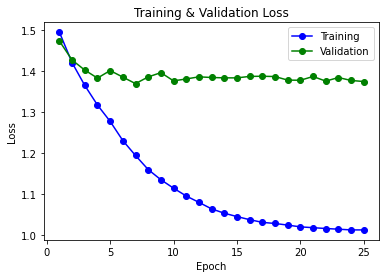

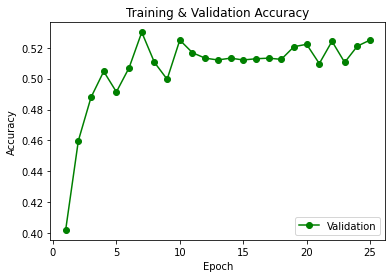

In [ ]:

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")
# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Here we compute predictions for the transformer over the test set and plot the corresdponding confusion matrix.

Report Performance

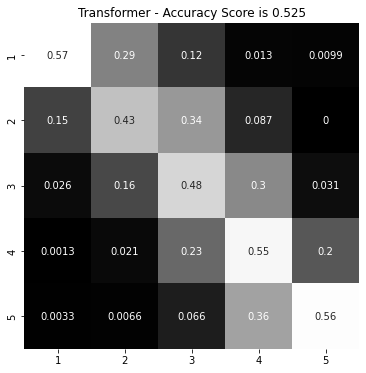

In [ ]:
true_labels, predictions = [], []
for step, batch in enumerate(test_dataloader):
    batch_inputs_masks_labels = tuple(b.to(device) for b in batch)
    batch_labels = batch_inputs_masks_labels[-1]
    batch_inputs_masks = batch_inputs_masks_labels[:-1]
    with torch.no_grad(): 
        outputs = model(batch_inputs_masks) 
        predictions += [np.argmax(pred) for pred in outputs.to('cpu').numpy()]
        true_labels += [batch_labels.to('cpu').numpy()]

predictions = np.hstack(predictions)+1
true_labels = np.hstack(true_labels)+1

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
norm_conf_mx = confusion_matrix(true_labels, predictions,labels=np.unique(true_labels))
norm_conf_mx = norm_conf_mx.astype('float') / norm_conf_mx.sum(axis=1)[:, np.newaxis]

fig,axarr = plt.subplots(1,1,figsize=(6,6))
ff = sn.heatmap(norm_conf_mx,ax=axarr,annot=True,cbar=False,cmap=plt.cm.gray,xticklabels=np.unique(true_labels),yticklabels=np.unique(true_labels));
axarr.set_title('Transformer - Accuracy Score is {:.3f}'.format(sum(predictions==true_labels)/len(true_labels)))
plt.show()